Notes
- maybe don't update movie vector?
- define source tables
- one table for user vectors (maybe store bias and features in the same row)
- one table for movie vectors
- try only updating user vectors with 1/2-1/2 split
- hav some pretrained model, movies not updated
- ralf server takes source, updates the original user vectors
- proper way is to point query own model, but for now it's stored as map inside operator
- operation might be too cheap, too fast in comparision with ralf overhead. could make operator artificially expensive?

Next Step:
    - research meeting tomorrow, maybe make some slides/present this?
    - use it with pre-computed movie vectors/biases 
    - what the distribution of updates are, if a lot of space between updates — need high density stream
        - need workload/updates to be hard, if it's trivial then there's no need, maybe not system problem? examine workload closer
        - could up features?
        - time each individual update and see (with movies)
    - should port to RALF first? might have to wait for simon to finish refactor
    - maybe one operator (update both vector & bias)?
    - if you had movie/user feature vector then you have different primary keys?
    - is it acceptable to point query another table?
        - source --> user --> movie

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

In [2]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
ratings_path = "/Users/amitnarang/Downloads/ml-100k/u.data"

In [9]:
columns=["user_id", "movie_id", "rating", "timestamp"]
df = pd.read_csv(ratings_path, sep = '\t', names=columns).sort_values('timestamp')

array([259, 851, 712])

In [37]:
def split_train_stream(df, percent_train):
    columns = list(df.columns)
    train_rows = percent_train * len(df)
    count = 0
    train_data = []
    stream_data = []
    for row in df.itertuples():
        data = [row.user_id, row.movie_id, row.rating, row.timestamp]
        if count < train_rows:
            train_data.append(data)
        else:
            stream_data.append(data)
        count += 1
    train_df = pd.DataFrame(data=train_data, columns=columns).sort_values("timestamp")
    stream_df = pd.DataFrame(data=stream_data, columns=columns).sort_values("timestamp")
    return train_df, stream_df

train_df, stream_df = split_train_stream(df, .5)
users = list(train_df['user_id'].unique())
users

[259,
 851,
 712,
 119,
 640,
 594,
 23,
 276,
 913,
 532,
 821,
 291,
 157,
 817,
 195,
 756,
 893,
 933,
 543,
 506,
 346,
 21,
 130,
 297,
 621,
 1,
 860,
 342,
 76,
 833,
 407,
 941,
 870,
 30,
 397,
 188,
 113,
 793,
 422,
 658,
 275,
 337,
 759,
 703,
 221,
 24,
 279,
 452,
 145,
 468,
 798,
 919,
 268,
 514,
 265,
 633,
 612,
 287,
 597,
 738,
 67,
 118,
 671,
 943,
 490,
 35,
 693,
 517,
 779,
 207,
 233,
 172,
 691,
 152,
 5,
 92,
 593,
 307,
 300,
 398,
 760,
 319,
 837,
 694,
 634,
 63,
 839,
 286,
 684,
 102,
 364,
 477,
 382,
 715,
 912,
 770,
 43,
 472,
 777,
 802,
 661,
 886,
 200,
 496,
 725,
 711,
 761,
 453,
 554,
 764,
 772,
 402,
 82,
 601,
 343,
 182,
 116,
 875,
 306,
 664,
 647,
 81,
 881,
 330,
 689,
 367,
 638,
 416,
 735,
 937,
 160,
 289,
 680,
 518,
 884,
 372,
 404,
 692,
 270,
 522,
 14,
 68,
 148,
 824,
 50,
 538,
 373,
 868,
 175,
 901,
 180,
 721,
 101,
 331,
 864,
 430,
 719,
 71,
 708,
 309,
 844,
 463,
 391,
 371,
 218,
 173,
 292,
 222,
 299,
 812,


In [43]:
n_users = max(train_df['user_id']) + 1
n_movies = max(train_df['movie_id']) + 1
ratings = np.zeros((n_users, n_movies))
for row in train_df.itertuples(index = False):
    print(row.user_id - 1)
    ratings[row.user_id - 1, row.movie_id - 1] = row.rating

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
850
850
850
850
850
850
850
850
850
850
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
711
850
850
850
850
850
850
850
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
639
118
118
593
593
593


112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
792
29
406
406
406
406
406
406
406
406
406
406
406
406
345
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
832
755
755
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
421
4

692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
692
516
75
75
75
75
75
778
778
778
778
778
778
778
778
942
778
942
942
778
778
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
942
778
942
942
942
942
942
942
778
778
778
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
232
232
232
232
232
232
232
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
206
531
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
267
267
267
267
267
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
690
406
406
4

471
471
471
471
471
471
471
471
776
776
471
471
471
471
776
776
471
471
471
471
471
471
776
776
776
471
776
776
776
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
776
776
776
776
471
471
776
776
776
776
776
776
776
471
471
471
471
776
776
471
471
776
776
776
776
776
776
776
776
776
776
776
776
776
471
471
471
471
471
471
42
42
471
471
42
42
42
42
42
42
42
42
42
471
471
42
42
42
42
471
471
42
42
471
471
42
42
471
471
42
42
42
42
42
42
42
42
471
471
471
42
42
42
42
471
42
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801
801


366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
232
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
637
531
531
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
415
734
734
734
734
415
415
734
734
734
734
734
734
415
415
415
415
415
415
415
415
415
734
734
734
734
734
734
734
734
734
415
415
415
415
415
415
415
415
415
415
415
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
734
415
734
734
734
734
734
415
415
415
415
415
415
415
415
415
415


179
179
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
172
291
291
291
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
814
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
735
221
221
221
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
761
424
424
424
424
424
424
424
424
424
424
424
424
424
869
869
424
424
424
424
424
424
424
869
424
424
424
424
424
869
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424
424


226
226
226
226
226
226
430
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
880
505
505
101
101
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
306
306
306
306
306
75
75
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
298
298
275
206
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
15

784
784
784
589
589
589
532
796
414
796
589
532
532
532
532
589
589
414
796
796
796
589
589
532
532
532
532
532
532
532
706
414
706
589
796
532
532
532
384
589
532
589
796
532
784
784
320
320
589
589
796
320
589
589
532
796
320
414
414
414
320
320
706
384
384
589
589
589
589
589
589
589
589
589
589
320
320
320
384
320
414
414
414
320
320
320
532
384
384
384
384
320
320
320
796
796
320
320
320
320
320
320
414
414
414
320
320
320
320
320
320
320
320
414
414
414
414
320
384
384
320
320
320
320
384
414
414
414
384
384
384
384
384
320
320
320
320
320
320
320
320
320
320
384
384
384
384
384
320
384
384
384
384
320
320
320
320
320
320
384
360
360
320
320
320
320
320
320
46
320
320
320
360
360
360
360
360
360
360
46
46
320
360
360
360
360
360
360
320
320
320
320
46
46
320
320
360
360
360
360
360
360
360
360
360
360
360
360
360
360
384
360
360
384
803
803
803
384
360
360
360
360
320
320
320
384
320
360
360
360
320
320
803
384
320
320
360
360
803
803
803
803
384
384
320
320
384
803
803
360
360
3

302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
384
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
302
354
354
354
354
302
302
302
302
302
302
302


633
671
633
671
671
671
445
445
445
671
538
538
538
538
538
538
538
538
538
538
538
538
671
671
538
445
445
445
445
445
538
538
671
671
671
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
81
81
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
671
748
671
671
671
748
671
671
671
671
671
671
671
671
671
671
671
671
402
402
402
402
402
402
402
402
402
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
623
623
261
623
261
261
623
623
623
623
261
261
623
623
623
261
261
261
623
623
623
623
623
623
623
623
623
623
261
623
623
623
261
623
623
261
261
261
623
623
623
623
623
623
261
623
623
623
261
261
623
623
623
623
623
623
623
623
623
623
623
623
623
623
623
623
715
261
261
261
623
623
623
623
623
715
623
623
623
261
261
261
261
261
405
405
405
405
405
405
405
405
405
405
261
261
261
405
405
405
405
405
405
405
405
405
261
405
405
405
405
405
405
405
261
405
405
40

71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
802
802
802
802
802
802
802
802
802
802
802
802
802
802
802
802
802
802
802
377
802
377
377
804
377
802
802
802
377
377
377
377
377
377
802
377
377
377
377
377
802
802
377
377
377
802
377
377
802
802
377
377
802
377
377
377
802
377
377
377
377
377
377
377
8

359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
9
818
818
818
818
436
436
436
436
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
502
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
922
206
922
922
502
502
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
373
37

787
787
787
877
787
787
787
787
877
877
877
877
877
877
877
877
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
787
877
877
877
877
877
877
877
877
787
787
787
787
787
787
787
787
787
787
787
877
877
877
877
877
877
384
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
393
377
377
505
505
206
206
275
275
275
275
275
275
275
275
275
275
275
275
859
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
605
605
605
605
605
605
605
605
605
605
605
605
605
605
605
605
605
605
232
232
23

483
483
483
483
483
483
483
483
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
384
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
194
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
105
226
226
667
667
667
667
667
667
667
667
667
667
667
667
667
667
794
794
794
794
794
794
794
794
794
794
794
794
794
794
384
384
384
384
129
129
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
275
384
377
667
667
667
667
667
94
94
748
748
748
748
748
667
667
667
667
667
667
667
667
667
667
298
298
667
893
893
893
893
893
893
893
893
258
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
565
56

449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
428
428
428
428
428
805
805
805
428
428
428
428
428
428
805
428
428
805
805
428
428
428
428
805
428
428
428
428
428
428
428
428
428
428
428
428
805
805
428
428
428
428
428
428
805
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
805
805
428
428
428
428
428
428
805
805
428
428
428
428
428
805
805
428
428
428
428
428
428
428
428
805
428
428
428
428
428
869
805
428
428
428
428
805
805
805
428
428
428
428
428
428
428
428
428
805
428
428
428
428
805
428
428
428
805
805
805
428
428
428
428
428
428
805
805
428
428
805
428
428
428
428
428
428
428
428
428
428
805
428
428
428
428
428
805
805
428
428
428
428
428
805
428
428
428
428
428
428
428
428
428
428
805
428
428
428
428
428
428
428
428
805
428
428
428
428
428
428


dimension:  (944, 1683)
sparsity: 3.1%


array([[5., 3., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
def create_train_test(ratings, users):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in users:
        nonzero_ratings = np.flatnonzero(ratings[user-1])
        test_index = np.random.choice(
            np.flatnonzero(ratings[user-1]), size = 1, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings, users)
del ratings
train

array([[5., 3., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [55]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

[4. 4. 3. 4. 4. 5. 3. 3. 3. 3. 4. 3. 5. 4. 5. 4. 5. 5. 3. 4. 2. 3. 4. 5.
 5. 4. 5. 5. 4. 4. 4. 5. 4. 2. 4. 5. 4. 4. 4. 3. 4. 4. 5. 3. 5. 3. 4. 4.
 4. 3. 2. 4. 3. 4. 5. 4. 4. 1. 4. 5.]
[-6.64634275e-01  1.60453138e+00  3.28609954e-01  8.85215547e-01
  3.25874551e-01  2.25004083e+00  9.52775110e-01  9.09315043e-01
  7.98207999e-01  8.17593267e-01  1.54962207e-01  1.19142539e+00
 -1.96304300e+00 -4.33677604e-01  2.52203418e+00  7.24315438e-01
  2.58358772e+00  2.02032172e+00  2.37778054e+00  1.49378055e+00
  1.48306755e+00  1.05852211e+00  4.60627551e-01  9.53875897e-01
  2.27789608e+00  1.21027335e+00  2.62527472e-01  1.61262712e+00
  1.40687820e-01  1.52052930e+00  9.60319266e-01  3.39801319e+00
  8.89774752e-01  2.93564252e-03 -1.95353039e+00  3.10239020e+00
  1.03245006e+00  1.20991001e+00  4.40642224e-01  3.85426924e-01
  2.15658350e+00  5.66967205e-01  2.15225734e+00  9.80496859e-01
  3.63427915e+00  1.47181376e+00  1.90050270e+00  2.77487256e+00
  1.53476919e+00  6.80626749e-01  1.

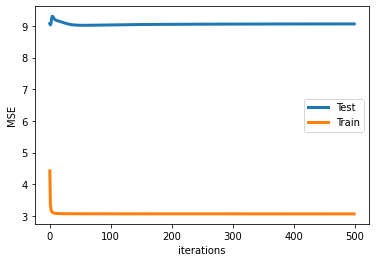

In [62]:
als = ExplicitMF(n_iters = 500, n_factors = 50, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)
mask = np.nonzero(test)
print(test[mask])
print(als.predict()[mask])

In [49]:
def split_train_test(df, num_test, num_users):
    columns = list(df.columns)
    train_data = []
    test_data = []
    for user_id in df["user_id"].unique():
        user_df = df[df["user_id"] == user_id].sort_values("timestamp")
        last_rows = user_df.tail(num_test)
        for row in user_df.itertuples():
            if row.user_id < num_users:
                data = [row.user_id, row.movie_id, row.rating, row.timestamp]
                if any(last_rows["movie_id"] == row.movie_id):
                    test_data.append(data)
                else:
                    train_data.append(data)
    train_df = pd.DataFrame(data=train_data, columns=columns).sort_values("timestamp")
    train_df = train_df.sample(frac=1)
    test_df = pd.DataFrame(data=test_data, columns=columns)
    return train_df, test_df

In [42]:
train_df, test_df = split_train_test(df, 5, 1000)
num_users = max(df['user_id'])
num_movies = max(df['movie_id'])

       user_id  movie_id  rating  timestamp
17526      259       255       4  874724710
17527      259       286       4  874724727
17528      259       298       4  874724754
17529      259       185       4  874724781
17530      259       173       4  874724843
...        ...       ...     ...        ...
75437      729       322       4  893286637
75439      729       362       4  893286637
75438      729       354       5  893286637
75441      729       300       4  893286638
75440      729       313       3  893286638

[95285 rows x 4 columns]


how to handle streaming sgd?

as we stream in a rating, update that movie's vector, that movie's bias, that user's vector, that user's bias

In [50]:
class ALSStreamingModel():
    
    def __init__(self, train_data, test_data, num_users, num_movies, num_features, learning_rate, user_bias_reg, movie_bias_reg, user_feature_reg, movie_feature_reg):
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = num_features
        
        self.global_bias = np.average(train_data['rating'])
        self.user_bias = np.zeros(self.num_users)
        self.movie_bias = np.zeros(self.num_movies)
        self.user_bias_reg = user_bias_reg
        self.movie_bias_reg = movie_bias_reg
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_users, self.num_features))
        self.movie_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_movies, self.num_features))
        self.user_feature_reg = user_feature_reg
        self.movie_feature_reg = movie_feature_reg
    
    def train(self):
        mse = []
        for row in self.train_data.itertuples():
            curr = time.time()
            if row.Index % 10 == 0:
                mse.append(self.compute_test_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            self.step(user_id, movie_id, rating)
            print(time.time()-curr)
        self.test_mse_record = mse
            
    def update_bias(self, user_id, movie_id, error):
        self.user_bias[user_id] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user_id])
        self.movie_bias[movie_id] += self.learning_rate * (error - self.movie_bias_reg * self.movie_bias[movie_id])
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id, :] += self.learning_rate * (error * self.movie_vectors[movie_id, :] - self.user_feature_reg * self.user_vectors[user_id,:])
        self.movie_vectors[movie_id, :] += self.learning_rate * (error * self.user_vectors[user_id, :] - self.movie_feature_reg * self.movie_vectors[movie_id,:])
        
    def predict_rating(self, user_id, movie_id):
        biases = self.global_bias + self.user_bias[user_id] + self.movie_bias[movie_id]
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return biases + prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def step(self, user_id, movie_id, rating):
        error = self.compute_prediction_error(user_id, movie_id, rating)
        self.update_bias(user_id, movie_id, error)
        self.update_features(user_id, movie_id, error)
            
    def compute_test_mse(self):
        predictions = []
        ratings = []
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse

In [51]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [52]:
def generate_optimal_hyperparameters():
    learning_rates = [1e-3, 1e-2, 1e-1]
    user_bias_reg = [1e-2, 1e-1, 2e-1]
    movie_bias_reg = [1e-2, 1e-1, 2e-1]
    user_feature_reg = [1e-2, 1e-1, 2e-1]
    movie_feature_reg = [1e-2, 1e-1, 2e-1]

    best_params = {}
    best_params['learning_rate'] = None
    best_params['user_bias_reg'] = None
    best_params['movie_bias_reg'] = None
    best_params['user_feature_reg'] = None
    best_params['movie_feature_reg'] = None
    best_params['train_mse'] = np.inf
    best_params['test_mse'] = np.inf
    best_params['model'] = None


    for rate in learning_rates:
        print(rate)
        for ubreg in user_bias_reg:
            for mbreg in movie_bias_reg:
                for ufreg in user_feature_reg:
                    for mfreg in movie_feature_reg:
                        als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 40, rate, ubreg, mbreg, ufreg, mfreg)
                        als.train()
                        test_mse = als.compute_test_mse()
                        if test_mse < best_params['test_mse']:
                            best_params['test_mse'] = test_mse
                            best_params['learning_rate'] = rate
                            best_params['train_mse'] = als.compute_train_mse()
                            best_params['user_bias_reg'] = ubreg
                            best_params['movie_bias_reg'] = mbreg
                            best_params['user_feature_reg'] = ufreg
                            best_params['movie_feature_reg'] = mfreg
                            best_params['model'] = als
                            print("New optimal parameters")
    return best_params

In [53]:
optimal_learning_rate = .1
optimal_ub_reg = .1
optimal_mb_reg = .01
optimal_uf_reg = .01
optimal_mf_reg = .1
train_df, test_df = train_df, test_df = split_train_test(df, 5, np.inf) 
als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 100, optimal_learning_rate, optimal_ub_reg, optimal_mb_reg, optimal_uf_reg, optimal_mf_reg)
als.train()

3.600120544433594e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009968042373657227
1.3113021850585938e-05
1.1205673217773438e-05
0.0072329044342041016
1.1205673217773438e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.009279966354370117
4.315376281738281e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-06
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
0.009634733200073242
1.5020370483398438e-05
1.0967254638671875e-05
0.009839057922363281
1.3113021850585938e-05
1.4066696166992188e-05
0.00829005241394043
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.00769495964050293
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
8.8214874267578

0.010125875473022461
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
1.3113021850585938e-05
9.059906005859375e-06
1.4066696166992188e-05
1.0251998901367188e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
1.2874603271484375e-05
1.4066696166992188e-05
9.059906005859375e-06
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
1.2874603271484375e-05
9.059906005859375e-06
1.1920928955078125e-05
0.01489400863647461
1.5974044799804688e-05
1.3113021850585938e-05
1.0967254638671875e-05
0.012612104415893555
0.010670900344848633
0.009936809539794922
0.012560129165649414
1.5020370483398438e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1205673217773438e-05
9.77516174

0.010781049728393555
1.6927719116210938e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1682510375976562e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
0.01114201545715332
1.811981201171875e-05
1.3828277587890625e-05
1.5020370483398438e-05
1.2874603271484375e-05
8.821487426757812e-06
1.2159347534179688e-05
0.010312080383300781
1.2159347534179688e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.010320186614990234
1.3113021850585938e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.010860204696655273
1.9073486328125e-05
1.3113021850585938e-05
0.009721755981445312
1.3113021850585938e-05
1.0013580322265625e-05
1.1682510375976562e-05
1.0013580322265625e-05
9.059906

0.009530782699584961
1.621246337890625e-05
1.0013580322265625e-05
0.01059103012084961
1.4066696166992188e-05
9.775161743164062e-06
0.011005878448486328
1.621246337890625e-05
0.010734081268310547
3.4809112548828125e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
0.011012077331542969
2.002716064453125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
1.8835067749023438e-05
1.4066696166992188e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
1.1682510375976562e-05
1.1920928955078125e-05
0.010942935943603516
1.4781951904296875e-05
1.0013580322265625e-05
0.00960683822631836
1.6927719116210938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0251998901367188

0.01033782958984375
1.5020370483398438e-05
1.4066696166992188e-05
1.0251998901367188e-05
1.0013580322265625e-05
0.01323080062866211
1.7881393432617188e-05
1.0013580322265625e-05
1.2874603271484375e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
0.009755134582519531
0.009772777557373047
0.010026931762695312
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
0.00966787338256836
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
1.2159347534179688e-05
0.009653091430664062
1.811981201171875e-05
1.2874603271484375e-05
1.0013580322265625e-05
0.009784936904907227
1.4066696166992188e-05
0.010128974914550781
1.3113021850585938e-05
1.0967254638671875e-05
0.00795292854309082
1.0967254638671875e-05
1.0967254638671875e

0.009719133377075195
2.5033950805664062e-05
2.193450927734375e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.01061701774597168
0.00843191146850586
0.006884098052978516
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.3113021850585938e-05
0.009314775466918945
1.4066696166992188e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009104251861572266
1.5020370483398438e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009473085403442383
1.811981201171875e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.009303092956542969
1.3828277587890625e-05
1.2636184692382812e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1682510

0.00017786026000976562
1.0967254638671875e-05
0.00946807861328125
1.9073486328125e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.0967254638671875e-05
9.775161743164062e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
0.01055908203125
0.0075762271881103516
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0251998901367188e-05
0.009927988052368164
1.3113021850585938e-05
0.007724761962890625
1.430511474609375e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
1.0251998901367188e-05
9.059906005859375e-06
1.4066696166992188e-05
9.298324584960938e-06
8.821487426757812e-06
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
4.9114227294921875e-05
1.2159347534179688e-0

0.01115107536315918
1.71661376953125e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.0013580322265625e-05
0.008630037307739258
3.3855438232421875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0251998901367188e-05
9.775161743164062e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1682510375976562e-05
3.1948089599609375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.011881113052368164
2.3126602172851562e-05
1.2159347534179688e-05
1.2874603271484375e-05
2.002716064453125e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.0251998901367188e-05
1.2159347534179688e-05
2.0265579223632812e-05
3.314018249511719e-05
1.0013580322265625e-05
1.0013580322265625e-05
1

0.010444879531860352
1.5974044799804688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.775161743164062e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.775161743164062e-06
9.059906005859375e-06
1.1920928955078125e-05
1.3113021850585938e-05
9.298324584960938e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
0.013410091400146484
3.409385681152344e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.02942800521850586
1.811981201171875e-05
0.008759021759033203
2.2172927856445312e-05
1.1920928955078125e-05
0.009039163589477539
9.226799011230469e-05
3.504753112792969e-05
4.887580871582031e-05
0.010700702667236328
1.9073486328125e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.775161743164062e-06
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.2874603271484375e-05
9.059906005859375e-06
9.775161743164062e-0

0.009737253189086914
1.71661376953125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0251998901367188e-05
9.059906005859375e-06
1.0013580322265625e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
0.014776229858398438
1.9073486328125e-05
1.0013580322265625e-05
0.014364957809448242
0.010481119155883789
1.3113021850585938e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-06
1.0013580322265625e-05
1.5735626220703125e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
0.010118246078491211
2.09808349609375e-05
1.5020370483398438e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1682510375976562e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0967254638671875e-05
0.009937286376953125
1.3113021850585938e-05
1.0251998901367188e-05
9.05990600585937

0.008975028991699219
1.5020370483398438e-05
1.2159347534179688e-05
9.059906005859375e-06
1.2874603271484375e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1682510375976562e-05
9.059906005859375e-06
1.0967254638671875e-05
0.010959863662719727
1.3113021850585938e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
8.106231689453125e-06
1.1920928955078125e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.3113021850585938e-05
0.011310100555419922
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.01042628288269043
1.6927719116210938e-05
1.71661376953125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.009571075439453125
1.7881393432617188e-05
1.4066696166992188e-05
9.059906005859375e-06
8.821487

0.01037287712097168
1.2874603271484375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
1.4066696166992188e-05
1.1920928955078125e-05
9.059906005859375e-06
1.3113021850585938e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
1.2874603271484375e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2874603271484375e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.3113021850585938e-05
0.013200044631958008
1.5974044799804688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
0.012282133102416992
1.2874603271484375e-05
1.3828277587890625e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.1682510375976562e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
4.601478576660156e-05
1.3113021850585938e-05
1.192

0.009339094161987305
1.2874603271484375e-05
1.3113021850585938e-05
1.5974044799804688e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
9.059906005859375e-06
0.010351896286010742
1.4781951904296875e-05
1.1205673217773438e-05
0.011448860168457031
1.1920928955078125e-05
1.3113021850585938e-05
1.4066696166992188e-05
1.1920928955078125e-05
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.775161743164062e-06
9.298324584960938e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.5020

0.010373830795288086
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.3113021850585938e-05
1.2636184692382812e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.3828277587890625e-05
1.1920928955078125e-05
0.010662078857421875
1.5974044799804688e-05
1.3113021850585938e-05
1.3113021850585938e-05
9.059906005859375e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
6.389617919921875e-05
1.0013580322265625e-05
9.298324584960938e-06
0.010103940963745117
1.5735626220703125e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.3113021850585938e-05


0.00953817367553711
1.3113021850585938e-05
1.0728836059570312e-05
0.009956836700439453
1.3113021850585938e-05
1.4066696166992188e-05
1.1920928955078125e-05
9.775161743164062e-06
9.059906005859375e-06
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.52587890625e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.013345003128051758
1.5735626220703125e-05
0.011287927627563477
0.010296106338500977
1.5735626220703125e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
0.00952601432800293
1.2159347534179688e-05
9.775161743164062e-06
1.1920928955078125e-05
8.821487426757812e-06
0.009020090103149414
1.5020370483398438e-05
3.314018249511719e-05
1.2874603271484375e-05
9.059906005859375e-06
0.009627819061279297
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
1.1682510375976562e-0

0.009552717208862305
1.2159347534179688e-05
0.011350870132446289
1.4781951904296875e-05
1.0967254638671875e-05
3.6716461181640625e-05
1.1205673217773438e-05
1.5974044799804688e-05
1.0967254638671875e-05
9.775161743164062e-06
1.0013580322265625e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.775161743164062e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
0.013458967208862305
1.6927719116210938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1682510375976562e-05
1.9788742065429688e-05
1.0967254638671875e-05
0.010524749755859375
1.52587890625e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
8.106231689453125e-06
9.059906005859375e-06
8.106231689453125e-06
1.1205673217773438e-05
1.0013580322265625e-05
8.821487

0.010480880737304688
0.007321834564208984
2.09808349609375e-05
1.0013580322265625e-05
1.621246337890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.009747028350830078
1.2636184692382812e-05
0.007417917251586914
1.1920928955078125e-05
2.193450927734375e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.009469985961914062
1.5974044799804688e-05
0.007551431655883789
1.3828277587890625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
0.009438037872314453
1.5735626220703125e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009086847305297852
1.3113021850585938e-05
1.1920928955078125e-05
0.008976221084594727
1.1920928955078125e-05
1.4066696166992188e-05
0.008682966232299805
1.62124633789062

0.009374856948852539
0.00988316535949707
0.01076817512512207
1.4066696166992188e-05
1.0013580322265625e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.0013580322265625e-05
0.01006007194519043
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.010790109634399414
1.5020370483398438e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
9.775161743164062e-06
1.1920928955078125e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.059906005859375e-06
8.106231689453125e-06
9.059906005859375e-06
8.106231689453125e-06
9.703636169433594e-05
0.010467052459716797
0.00933980941772461
1.52587890625e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
7.867813110351562e-06
8.344650268554688e-06
0.009778976440429688


0.015907764434814453
1.2874603271484375e-05
1.1205673217773438e-05
2.193450927734375e-05
2.3126602172851562e-05
1.1920928955078125e-05
2.002716064453125e-05
1.0967254638671875e-05
1.0013580322265625e-05
4.601478576660156e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.8358230590820312e-05
0.010463953018188477
1.2636184692382812e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.621246337890625e-05
1.7881393432617188e-05
1.1205673217773438e-05
1.5020370483398438e-05
8.893013000488281e-05
1.0967254638671875e-05
9.059906005859375e-06
1.4066696166992188e-05
1.6689300537109375e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.0967254638671875e-05
1.6927719116210938e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.016441822052001953
1.0967254638671875e-05
0.0075609683990478516
1.3113021850585938e-05
0.009075164794921875
1.2874603271484375e-05
1.4066696166992188e-05
2.7894973754882812e-05
1.621246337890625e-05
1.31

0.016637325286865234
1.0967254638671875e-05
2.09808349609375e-05
0.008522987365722656
1.0967254638671875e-05
1.0251998901367188e-05
4.506111145019531e-05
2.193450927734375e-05
2.4080276489257812e-05
2.09808349609375e-05
1.7881393432617188e-05
1.3113021850585938e-05
1.0967254638671875e-05
0.010088920593261719
4.100799560546875e-05
0.007425069808959961
0.0001380443572998047
1.71661376953125e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.52587890625e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
3.2901763916015625e-05
2.09808349609375e-05
1.1205673217773438e-05
1.2159347534179688e-05
2.6941299438476562e-05
0.00010395050048828125
1.811981201171875e-05
1.430511474609375e-05
1.52587890625e-05
0.009526968002319336
1.2159347534179688e-05
1.5020370483398438e-05
1.5020370483398438e-05
1.4066696166992188e-05
2.09808349609375e-05
1.3828277587890625e-05
0.008815765380859375
1.2159347534179688e-05
1.6927719116210938e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.096

0.010039806365966797
1.1682510375976562e-05
0.0075418949127197266
2.7894973754882812e-05
2.7894973754882812e-05
1.1920928955078125e-05
1.5020370483398438e-05
0.008701086044311523
0.00730586051940918
2.9802322387695312e-05
0.00010132789611816406
0.0076999664306640625
4.506111145019531e-05
0.0001881122589111328
1.8835067749023438e-05
1.5020370483398438e-05
8.20159912109375e-05
1.0967254638671875e-05
1.5974044799804688e-05
1.2159347534179688e-05
2.002716064453125e-05
6.198883056640625e-05
1.6927719116210938e-05
2.8133392333984375e-05
0.008987903594970703
1.5735626220703125e-05
1.2874603271484375e-05
1.71661376953125e-05
1.4781951904296875e-05
1.5020370483398438e-05
1.1920928955078125e-05
1.52587890625e-05
2.09808349609375e-05
1.5974044799804688e-05
1.4066696166992188e-05
1.0967254638671875e-05
2.09808349609375e-05
1.71661376953125e-05
0.012537002563476562
0.0001590251922607422
1.4066696166992188e-05
1.1920928955078125e-05
6.604194641113281e-05
1.1920928955078125e-05
1.1205673217773438e-05

0.016366004943847656
3.2901763916015625e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.9788742065429688e-05
1.2874603271484375e-05
2.384185791015625e-05
1.1682510375976562e-05
1.5735626220703125e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.430511474609375e-05
2.09808349609375e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.5974044799804688e-05
1.811981201171875e-05
1.5735626220703125e-05
2.002716064453125e-05
0.016108989715576172
0.00719904899597168
0.00011897087097167969
1.4066696166992188e-05
1.2159347534179688e-05
1.1920928955078125e-05
8.487701416015625e-05
2.2172927856445312e-05
2.4080276489257812e-05
1.4066696166992188e-05
1.1920928955078125e-05
2.4080276489257812e-05
2.193450927734375e-05
1.811981201171875e-05
0.009804010391235352
0.007342100143432617
0.00013303756713867188
1.5735626220703125e-05
1.0013580322265625e-05
0.00836181640625
1.1920928955078125e-05
2.193450927734375e-05
7.605552673339844e-05
1.1205673217773438e-05
0.008005857467651367
7.677078247070312e

0.015078067779541016
0.00829315185546875
1.4066696166992188e-05
1.1682510375976562e-05
1.0967254638671875e-05
1.6927719116210938e-05
1.2636184692382812e-05
2.574920654296875e-05
2.09808349609375e-05
2.09808349609375e-05
1.4066696166992188e-05
1.6927719116210938e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.4781951904296875e-05
2.002716064453125e-05
1.1920928955078125e-05
1.621246337890625e-05
1.3828277587890625e-05
1.3828277587890625e-05
1.5974044799804688e-05
1.71661376953125e-05
1.71661376953125e-05
1.4066696166992188e-05
1.2636184692382812e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.8835067749023438e-05
1.6927719116210938e-05
3.719329833984375e-05
2.3126602172851562e-05
2.09808349609375e-05
1.0967254638671875e-05
1.71661376953125e-05
1.0967254638671875e-05
1.1205673217773438e-05
2.3126602172851562e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.0212459

0.010447025299072266
3.314018249511719e-05
2.09808349609375e-05
2.4080276489257812e-05
3.600120544433594e-05
1.430511474609375e-05
1.0013580322265625e-05
8.821487426757812e-06
2.5033950805664062e-05
1.1920928955078125e-05
1.71661376953125e-05
0.009063005447387695
0.007502079010009766
0.007388114929199219
1.2159347534179688e-05
0.007400989532470703
1.2159347534179688e-05
2.193450927734375e-05
0.00755000114440918
1.4066696166992188e-05
1.5020370483398438e-05
2.6226043701171875e-05
1.3828277587890625e-05
1.811981201171875e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.010539054870605469
1.0967254638671875e-05
0.007452964782714844
1.4066696166992188e-05
0.008487224578857422
1.1920928955078125e-05
1.52587890625e-05
1.5020370483398438e-05
2.09808349609375e-05
1.0967254638671875e-05
1.6689300537109375e-05
1.9073486328125e-05
2.384185791015625e-05
0.013091087341308594
1.2874603271484375e-05
0.007522106170654297
1.1920928955078125e-05
9.608268737792969e-05
1.621246337890625e-05
1.096725463

0.010410785675048828
1.1920928955078125e-05
2.002716064453125e-05
0.00911092758178711
4.506111145019531e-05
0.007604122161865234
1.4066696166992188e-05
0.007377147674560547
1.7881393432617188e-05
3.504753112792969e-05
1.0013580322265625e-05
2.7179718017578125e-05
2.9325485229492188e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.52587890625e-05
1.3828277587890625e-05
1.621246337890625e-05
0.00010704994201660156
0.008777856826782227
0.0071451663970947266
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.9073486328125e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.2874603271484375e-05
2.574920654296875e-05
1.811981201171875e-05
1.1920928955078125e-05
1.6689300537109375e-05
1.4066696166992188e-05
1.4066696166992188e-05
0.013329029083251953
4.1961669921875e-05
1.9073486328125e-05
1.5020370483398438e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.0967254638671875e-05
3.695487976074219e-05
2.2172927856445312e-05
1.7881393432617188e-05


0.00881505012512207
1.4066696166992188e-05
1.3828277587890625e-05
0.007722139358520508
1.0967254638671875e-05
1.3113021850585938e-05
1.8358230590820312e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.3828277587890625e-05
1.9073486328125e-05
1.3828277587890625e-05
1.6689300537109375e-05
1.0967254638671875e-05
1.9311904907226562e-05
0.011222124099731445
1.1682510375976562e-05
1.1920928955078125e-05
1.430511474609375e-05
1.0013580322265625e-05
0.009385824203491211
1.1205673217773438e-05
1.7881393432617188e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.621246337890625e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.3113021850585938e-05
1.5974044799804688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.6927719116210938e-05
2.193450927734375e-05
1.0967254638671875e-05
1.9073486328125e-05
0.01935267448425293
1.6927719116210938e-05
8.821487426757812e-06
1.9073486328125e-05
1.38282775878

0.02137303352355957
0.007391929626464844
1.2874603271484375e-05
1.3828277587890625e-05
1.0967254638671875e-05
0.009319067001342773
3.2901763916015625e-05
0.0074040889739990234
1.3113021850585938e-05
1.5020370483398438e-05
1.0967254638671875e-05
0.007779121398925781
1.5735626220703125e-05
1.0967254638671875e-05
1.3828277587890625e-05
1.7881393432617188e-05
1.6927719116210938e-05
0.008697032928466797
1.2159347534179688e-05
1.811981201171875e-05
0.00906991958618164
1.0967254638671875e-05
9.059906005859375e-06
1.1205673217773438e-05
1.71661376953125e-05
1.4066696166992188e-05
7.605552673339844e-05
1.3113021850585938e-05
1.52587890625e-05
0.010725021362304688
1.1920928955078125e-05
1.0013580322265625e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.0013580322265625e-05
2.8848648071289062e-05
2.8133392333984375e-05
8.821487426757812e-06
7.605552673339844e-05
1.0013580322265625e-05
1.0728836059570312e-05
1.621246337890625e-05
1.3113021850585938e-05
0.013257980346679688
1.0967254638671875e-

0.020029306411743164
1.6927719116210938e-05
0.014840841293334961
0.008131980895996094
4.1961669921875e-05
0.000102996826171875
1.1920928955078125e-05
1.0013580322265625e-05
6.604194641113281e-05
1.5020370483398438e-05
1.9073486328125e-05
1.3113021850585938e-05
6.794929504394531e-05
1.1205673217773438e-05
1.2159347534179688e-05
1.4066696166992188e-05
6.699562072753906e-05
1.1920928955078125e-05
1.8835067749023438e-05
1.3113021850585938e-05
9.059906005859375e-06
8.797645568847656e-05
1.5974044799804688e-05
6.4849853515625e-05
1.6689300537109375e-05
1.621246337890625e-05
2.5272369384765625e-05
0.010883092880249023
1.2159347534179688e-05
0.00011968612670898438
1.5020370483398438e-05
1.0251998901367188e-05
1.0967254638671875e-05
9.274482727050781e-05
0.008244991302490234
1.4066696166992188e-05
0.0001232624053955078
1.2159347534179688e-05
1.4066696166992188e-05
1.52587890625e-05
1.9073486328125e-05
1.2636184692382812e-05
0.011141061782836914
1.4066696166992188e-05
2.288818359375e-05
0.008995

0.008852958679199219
2.6226043701171875e-05
4.8160552978515625e-05
7.200241088867188e-05
1.4781951904296875e-05
1.1920928955078125e-05
1.52587890625e-05
1.0967254638671875e-05
2.002716064453125e-05
1.1920928955078125e-05
2.002716064453125e-05
1.9788742065429688e-05
1.1682510375976562e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.71661376953125e-05
1.7881393432617188e-05
2.384185791015625e-05
1.4066696166992188e-05
1.2874603271484375e-05
2.0265579223632812e-05
1.5974044799804688e-05
1.0728836059570312e-05
1.5974044799804688e-05
1.621246337890625e-05
1.3828277587890625e-05
1.52587890625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.4781951904296875e-05
1.0013580322265625e-05
1.71661376953125e-05
1.5974044799804688e-05
0.020476102828979492
1.811981201171875e-05
1.9073486328125e-05
1.0967254638671875e-05
1.3113021850585938e-05
2.09808349609375e-05
1.621246337890625e-05
1.5974044799804688e-05
1.9788742065429688e-05
1.8358230590820312e-05
6.4849853515625e-05
1.3113021850585938e-05

0.019914865493774414
1.4781951904296875e-05
1.5020370483398438e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.8835067749023438e-05
2.002716064453125e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.775161743164062e-06
8.821487426757812e-06
1.1920928955078125e-05
1.0013580322265625e-05
2.6941299438476562e-05
0.012775182723999023
3.814697265625e-05
2.09808349609375e-05
1.2874603271484375e-05
0.00013113021850585938
1.7881393432617188e-05
1.9788742065429688e-05
1.5974044799804688e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.5735626220703125e-05
1.0967254638671875e-05
0.010233163833618164
0.00728607177734375
1.0967254638671875e-05
1.2159347534179688e-05
1.5974044799804688e-05
1.1920928955078125e-05
2.09808349609375e-05
1.2159347534179688e-05
1.5974044799804688e-05
1.6927719116210938e-05
1.5020370483398438e-05
1.4781951904296875e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.311302

0.012043952941894531
1.2874603271484375e-05
1.2159347534179688e-05
1.71661376953125e-05
1.3828277587890625e-05
0.009629249572753906
1.1920928955078125e-05
1.4066696166992188e-05
4.363059997558594e-05
1.3828277587890625e-05
1.1205673217773438e-05
1.0967254638671875e-05
0.011013984680175781
1.0967254638671875e-05
1.1920928955078125e-05
1.3828277587890625e-05
1.4781951904296875e-05
1.2159347534179688e-05
2.5033950805664062e-05
1.621246337890625e-05
1.4066696166992188e-05
1.7881393432617188e-05
1.5735626220703125e-05
0.01324915885925293
0.007139921188354492
1.1205673217773438e-05
9.059906005859375e-06
1.0013580322265625e-05
0.009348869323730469
1.2874603271484375e-05
1.430511474609375e-05
1.7881393432617188e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.7881393432617188e-05
1.71661376953125e-05
1.5974044799804688e-05
1.3113021850585938e-05
1.8358230590820312e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.01750016212463379
1.0013580322265625e-05
9.0599060058

0.01962113380432129
1.0967254638671875e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.5974044799804688e-05
1.4066696166992188e-05
1.7881393432617188e-05
1.5735626220703125e-05
1.811981201171875e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.621246337890625e-05
1.71661376953125e-05
1.8358230590820312e-05
0.014480113983154297
1.3113021850585938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3828277587890625e-05
1.621246337890625e-05
1.7881393432617188e-05
1.3828277587890625e-05
1.3828277587890625e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.3589859008789062e-05
1.2159347534179688e-05
1.52587890625e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.71661376953125e-05
6.29425048828125e-05
1.0013580322265625e-05
9.059906005859375e-06
0.018948793411254883
1.0967254638671875e-05
9.059906005859375e-06
1.1205673217773438e-05
1.668930053

1.621246337890625e-05
1.2636184692382812e-05
4.410743713378906e-05
2.5033950805664062e-05
1.2636184692382812e-05
1.621246337890625e-05
1.3113021850585938e-05
1.811981201171875e-05
1.5020370483398438e-05
1.5735626220703125e-05
1.5020370483398438e-05
1.5735626220703125e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.4781951904296875e-05
1.2874603271484375e-05
1.5020370483398438e-05
1.0013580322265625e-05
1.9073486328125e-05
1.0013580322265625e-05
1.4066696166992188e-05
1.52587890625e-05
0.020402193069458008
0.007021903991699219
1.2874603271484375e-05
1.811981201171875e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.4781951904296875e-05
2.002716064453125e-05
1.5974044799804688e-05
1.3828277587890625e-05
1.0967254638671875e-05
1.71661376953125e-05
1.5020370483398438e-05
1.2874603271484375e-05
1.621246337890625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.2874603271484375e-05
0.016676664352416992
1.2159347534179688e-05
1.71661376953125e-05
1.31130218505

0.017384052276611328
1.0967254638671875e-05
2.288818359375e-05
1.1205673217773438e-05
1.6927719116210938e-05
2.1219253540039062e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.621246337890625e-05
1.4066696166992188e-05
1.5020370483398438e-05
1.621246337890625e-05
1.7881393432617188e-05
1.0013580322265625e-05
1.4781951904296875e-05
1.52587890625e-05
1.2874603271484375e-05
1.5735626220703125e-05
1.621246337890625e-05
1.7881393432617188e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.5020370483398438e-05
1.9311904907226562e-05
1.3113021850585938e-05
1.6927719116210938e-05
1.4781951904296875e-05
1.9788742065429688e-05
1.811981201171875e-05
0.021416902542114258
1.52587890625e-05
1.5020370483398438e-05
1.1205673217773438e-05
2.09808349609375e-05
1.2874603271484375e-05
1.6927719116210938e-05
1.3828277587890625e-05
1.4066696166992188e-05
1.7881393432617188e-05
0.008509159088134766
0.006819009780883789
1.0967254638671875e-05
1.0013580322265625e-05
1.4781951904296875e-05
2.00271606445312

0.01687908172607422
1.3828277587890625e-05
1.3113021850585938e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.9073486328125e-05
0.009572982788085938
1.4781951904296875e-05
0.00010991096496582031
1.621246337890625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.9788742065429688e-05
8.797645568847656e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.811981201171875e-05
1.4066696166992188e-05
0.009774923324584961
0.006931781768798828
1.0013580322265625e-05
1.3113021850585938e-05
1.8835067749023438e-05
1.4066696166992188e-05
1.2874603271484375e-05
1.811981201171875e-05
1.4066696166992188e-05
1.2636184692382812e-05
0.009342193603515625
1.0967254638671875e-05
1.8835067749023438e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.8835067749023438e-05
0.010548830032348633
1.0013580322265625e-05
2.0265579223632812e-05
0.007642984390258789
1.3828277587890625e-05
0.0069141387939453125
1.2636184692382812e-05
1.5020370483398438e-05
1.9073486328125e-05
1.311302185058

0.014857053756713867
1.0967254638671875e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.71661376953125e-05
1.8358230590820312e-05
1.811981201171875e-05
1.9073486328125e-05
0.015447616577148438
0.007224082946777344
1.4066696166992188e-05
1.9073486328125e-05
1.8835067749023438e-05
1.1920928955078125e-05
0.008466958999633789
1.3828277587890625e-05
1.5020370483398438e-05
1.1920928955078125e-05
1.5020370483398438e-05
0.010577201843261719
1.3113021850585938e-05
1.3828277587890625e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.5020370483398438e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.811981201171875e-05
1.52587890625e-05
1.1920928955078125e-05
9.775161743164062e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.4066696166992188e-05
4.291534423828125e-05
1.3828277587890625e-05
6.985664367675781e-05
1.1920928955078125e-05
1.3828277587890625e-05
1.0967254638671875e-05
1.811981201171875e-05
1.1205673217773438e-05
0.019183874130249023
1.4781951904296875e-05
9.059906005859375e-

0.018592119216918945
1.7881393432617188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.4781951904296875e-05
1.621246337890625e-05
1.0013580322265625e-05
2.09808349609375e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.015909910202026367
1.1920928955078125e-05
0.008263826370239258
1.0967254638671875e-05
0.007375240325927734
1.0013580322265625e-05
9.059906005859375e-06
1.3828277587890625e-05
1.5974044799804688e-05
1.3828277587890625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.4781951904296875e-05
1.6689300537109375e-05
1.7881393432617188e-05
1.71661376953125e-05
1.5735626220703125e-05
1.2636184692382812e-05
1.2636184692382812e-05
1.621246337890625e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.6927719116210938e-05
1.0013580322265625e-05
1.5974044799804688e-05
1.5020370483398438e-05
1.3113021850585938e-05
1.7881393432617188e-05
1.8358230590820312e-05
1.1205673217773438e-05
1.4781951904296875e-05
1.5020370483398438e-05
1.5974044799804688e-05
1.0

0.011518001556396484
1.2159347534179688e-05
0.0071408748626708984
0.00012683868408203125
1.71661376953125e-05
0.007422924041748047
0.006909847259521484
1.0967254638671875e-05
6.67572021484375e-05
1.6927719116210938e-05
1.8835067749023438e-05
1.4066696166992188e-05
1.5974044799804688e-05
1.1205673217773438e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2636184692382812e-05
1.811981201171875e-05
1.5974044799804688e-05
1.3113021850585938e-05
1.9073486328125e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.811981201171875e-05
1.621246337890625e-05
1.3113021850585938e-05
2.002716064453125e-05
2.002716064453125e-05
1.7881393432617188e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.5735626220703125e-05
1.7881393432617188e-05
1.7881393432617188e-05
1.71661376953125e-05
1.3113021850585938e-05
1.811981201171875e-05
1.5020370483398438e-05
1.8358230590820312e-05
1.7881393432617188e-05
1.2874603271484375e-05
1.3828277587890625e-05
1.3828277587890625e-05
1.5974044799804688e-05
1.57356262

0.009427785873413086
1.2159347534179688e-05
1.3113021850585938e-05
9.059906005859375e-06
0.010310888290405273
2.002716064453125e-05
1.1682510375976562e-05
9.059906005859375e-06
9.775161743164062e-06
1.0013580322265625e-05
0.012953996658325195
3.790855407714844e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.012067079544067383
1.6927719116210938e-05
1.0251998901367188e-05
8.821487426757812e-06
1.3828277587890625e-05
0.013630867004394531
1.4781951904296875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.012015819549560547
2.5033950805664062e-05
1.0967254638671875e-05
0.009537935256958008
1.2159347534179688e-05
1.4781951904296875e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
1.28746032714

0.009649991989135742
0.01182103157043457
1.5974044799804688e-05
1.1205673217773438e-05
1.0251998901367188e-05
1.1205673217773438e-05
1.0013580322265625e-05
9.059906005859375e-06
1.3828277587890625e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.298324584960938e-06
1.0013580322265625e-05
0.012956857681274414
1.5020370483398438e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2874603271484375e-05
8.821487426757812e-06
1.1682510375976562e-05
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
0.0001010894775390625
1.4066696166992188e-05
1.4066696166992188e-05
8.821487426757812e-06
0.011575937271118164
1.2874603271484375e-05
1.1920928955078125e-05
0.010148048400878906
1.5020370483398438e-05
0.010566234588623047
1.5020370483398438e-05
1.4066696166992188e-05
0.00984501838684082
1.5020370483398438e-05
1.2159347534179688e-05
1.2874603271

0.009729146957397461
1.5735626220703125e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.2159347534179688e-05
0.010446786880493164
1.5020370483398438e-05
1.5020370483398438e-05
0.012789011001586914
1.8358230590820312e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010029077529907227
1.3113021850585938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0251998901367188e-05
0.009863853454589844
1.5974044799804688e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
0.009972095489501953
1.71661376953125e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.009604215621948242
1.3113021850585938e-05
0.009915828704833984
1.811981201171875e-05
0.009633064270019531
1.3113021850585938e-05
1.1920928955078125e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
0.009439945220947266
1.621246337890625e-05
1.0967254638671875e-05
1.0251998901367188e-05
8.8214874267578

0.01116633415222168
0.014636993408203125
0.007996082305908203
3.0040740966796875e-05
1.0967254638671875e-05
0.007565021514892578
1.5974044799804688e-05
1.3113021850585938e-05
1.7881393432617188e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.059906005859375e-06
9.298324584960938e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2874603271484375e-05
0.010872840881347656
1.5020370483398438e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2874603271484375e-05
0.0001049041748046875
1.0967254638671875e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.82148742

0.009294986724853516
1.52587890625e-05
0.009791374206542969
2.2172927856445312e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.0013580322265625e-05
0.011329889297485352
1.1920928955078125e-05
1.3828277587890625e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
1.6927719116210938e-05
1.0967254638671875e-05
0.00010514259338378906
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.2874603271484375e-05
1.0013580322265625e-05
1.1682510375976562e-05
0.011430978775024414
1.5020370483398438e-05
0.01328587532043457
1.621246337890625e-05
1.4066696166992188e-05
0.013009786605834961
2.6941299438476562e-05
2.5272369384765625e-05
1.0013580322265625e-05
1.7881393432617188e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
0.010441064834594727
1.3113021850585938e-05
1.2874603271484375e-0

0.010023117065429688
1.52587890625e-05
2.002716064453125e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
1.2159347534179688e-05
1.2159347534179688e-05
0.011709928512573242
1.52587890625e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.1682510375976562e-05
0.011088848114013672
1.2159347534179688e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.2874603271484375e-05
8.821487426757812e-06
7.867813110351562e-06
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
7.867813110351562e-06
0.009263277053833008
1.3113021850585938e-05
1.0013580322265625e-0

0.009484052658081055
0.010225296020507812
0.0069429874420166016
2.09808349609375e-05
1.0967254638671875e-05
2.09808349609375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0251998901367188e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
0.010111808776855469
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
0.009217977523803711
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
0.009494781494140625
1.4781951904296875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
1.1205673217773438e-05
1.1920928955078125e-05
1.215934753417

0.01203012466430664
1.3113021850585938e-05
1.0251998901367188e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.6927719116210938e-05
1.0967254638671875e-05
2.5033950805664062e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
1.2874603271484375e-05
9.059906005859375e-06
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-06
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
1.3113021850585938e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
0.012992143630981445
1.811981201171875e-05
1.0967254638671875e-05
0.013067007064819336
2.002716064453125e-05
1.2159347534179688e-05
1.40666961669921

0.011339187622070312
2.09808349609375e-05
1.0967254638671875e-05
0.009154796600341797
3.4809112548828125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
0.008738040924072266
1.1920928955078125e-05
0.009156227111816406
1.0967254638671875e-05
1.621246337890625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
0.009617328643798828
0.0077190399169921875
3.790855407714844e-05
1.1205673217773438e-05
9.775161743164062e-06
1.0967254638671875e-05
1.0013580322265625e-05
0.009337663650512695
4.6253204345703125e-05
1.1920928955078125e-05
1.0728836059570312e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.010129928588867188
1.430511474609375e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.010120868682861328
3.981590270996094e-05
1.2874603271484375e-05
1.1682510375976562e-05
1.0967254638671875e-05
1.12056732177

0.012360095977783203
2.002716064453125e-05
1.3113021850585938e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.3113021850585938e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
4.482269287109375e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
0.011281967163085938
1.1920928955078125e-05
1.430511474609375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.010605096817016602
1.4066696166992188e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.50203

0.009998083114624023
1.2636184692382812e-05
1.1920928955078125e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1682510375976562e-05
0.01011514663696289
2.002716064453125e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.011751174926757812
1.71661376953125e-05
1.0013580322265625e-05
1.5735626220703125e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.007953882217407227
1.7881393432617188e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.009785890579223633
1.3828277587890625e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.1682510375976562e-05
0.008614778518676758
2.4080276489257812e-05
1.3828277587890625e-05
0.007675886154174805
1.0967254638671875e-05
1.0728836059570312e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
8.821487426757812e-06
2.5749206542

0.01030588150024414
1.6689300537109375e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.1682510375976562e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
0.010679006576538086
1.5735626220703125e-05
1.2874603271484375e-05
0.012270927429199219
0.007966041564941406
0.006697416305541992
0.006979942321777344
1.4066696166992188e-05
0.00914311408996582
1.1920928955078125e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
0.009734153747558594
1.0967254638671875e-05
1.5020370483398438e-05
9.059906005859375e-06
0.007899045944213867
0.007592916488647461
1.4066696166992188e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.05990600585937

0.0231931209564209
0.0002071857452392578
4.1961669921875e-05
1.2159347534179688e-05
0.017598867416381836
3.314018249511719e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
0.019091367721557617
2.09808349609375e-05
0.013113260269165039
0.013515949249267578
0.013980865478515625
0.010827779769897461
1.3113021850585938e-05
1.0967254638671875e-05
0.007774829864501953
1.1920928955078125e-05
9.775161743164062e-06
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.0251998901367188e-05
1.2159347534179688e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
7.867813110351562e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
0.01052999496459961
1.788139343

0.011050939559936523
1.5974044799804688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2874603271484375e-05
1.2874603271484375e-05
8.821487426757812e-06
8.821487426757812e-06
0.011015892028808594
1.621246337890625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.2159347534179688e-05
0.009867191314697266
1.1920928955078125e-05
1.5020370483398438e-05
1.2159347534179688e-05
1.2159347534179688e-05
8.821487426757812e-06
9.775161743164062e-06
8.821487426757812e-06
1.1205673217773438e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.011164188385009766
1.3113021850585938e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1205673217773438e-05
0.008213043212890625
0.006871938705444336
0.006902933120727539
1.1920928955078125e-05
1.0967254638671875e-05
0.007891416549682617
1.0967254638671875e-05
2.002716064453125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.406669616699

0.009340047836303711
1.52587890625e-05
1.4066696166992188e-05
9.298324584960938e-06
1.2159347534179688e-05
0.009960174560546875
1.1920928955078125e-05
2.002716064453125e-05
1.1682510375976562e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1205673217773438e-05
0.010805130004882812
1.2159347534179688e-05
1.0013580322265625e-05
9.775161743164062e-06
0.007406949996948242
1.1205673217773438e-05
1.0967254638671875e-05
0.008127212524414062
1.0967254638671875e-05
1.1682510375976562e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.2636184692382812e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1205673217773438e-05
0.009219646453857422
1.6689300537109375e-05
1.1205673217773438e-05
0.009399175643920898
1.8358230590820312e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.311302185058

0.009792089462280273
1.52587890625e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.775161743164062e-06
7.867813110351562e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
0.010699987411499023
1.52587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
0.00972890853881836
0.009575843811035156
1.4781951904296875e-05
1.7881393432617188e-05
1.3113021850585938e-05
9.298324584960938e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1205673217773438e-05
0.00957798957824707
1.5020370483398438e-05
1.0013580322265625e-05
0.009343862533569336
1.3828277587890625e-05
1.2874603271484375e-05
1.430511474609375e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1

0.012257099151611328
1.2874603271484375e-05
1.1205673217773438e-05
1.0013580322265625e-05
2.09808349609375e-05
1.3113021850585938e-05
0.008285045623779297
1.1682510375976562e-05
1.8835067749023438e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.008600950241088867
0.006796836853027344
1.3828277587890625e-05
1.0013580322265625e-05
0.007651090621948242
1.0967254638671875e-05
1.2159347534179688e-05
0.007253170013427734
1.5974044799804688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.3113021850585938e-05
0.009859800338745117
2.002716064453125e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
8.106231689453125e-06
1.3113021850585938e-05
0.009438037872314453
1.2874603271484375e-05
1.2159347534179688e-05
1.1920928955078125e-05
2.002716064453125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0967254638671875e-05
1.692771911

0.011307001113891602
1.3113021850585938e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.011511087417602539
1.2874603271484375e-05
1.0013580322265625e-05
9.775161743164062e-06
1.4066696166992188e-05
0.009498119354248047
1.621246337890625e-05
1.3113021850585938e-05
1.2159347534179688e-05
8.821487426757812e-06
0.009444952011108398
1.1682510375976562e-05
0.009150981903076172
1.52587890625e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.3113021850585938e-05
9.775161743164062e-06
8.821487426757812e-06
1.0013580322265625e-05
0.009850025177001953
2.4080276489257812e-05
1.1920928955078125e-05
9.059906005859375e-06
1.4066696166992188e-05
1.5735626220703125e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
0.010769844055175781
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.009167194366455078
1.0967254638671875e-0

0.009501934051513672
1.4781951904296875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009923934936523438
1.3113021850585938e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0967254638671875e-05
9.059906005859375e-06
8.106231689453125e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
0.00949716567993164
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009683847427368164
1.4781951904296875e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
1.1920928955078125e-05
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.2159347534179688e-05
1.2874603271484375e-05
9.775161743164062e-06
1.0013580322265625e-05
1.1920928955078125e-05
9.059906005859375e-06
1.09672

0.010720014572143555
2.6226043701171875e-05
1.4066696166992188e-05
0.009613990783691406
1.1920928955078125e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
1.3113021850585938e-05
9.298324584960938e-06
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.009852170944213867
2.09808349609375e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010548114776611328
1.4066696166992188e-05
0.01047

0.00944209098815918
1.7881393432617188e-05
1.1920928955078125e-05
8.821487426757812e-06
9.298324584960938e-06
1.2159347534179688e-05
0.009603023529052734
1.52587890625e-05
1.3828277587890625e-05
1.0013580322265625e-05
0.009268999099731445
1.4781951904296875e-05
1.2636184692382812e-05
1.0013580322265625e-05
0.013152837753295898
1.3113021850585938e-05
1.0967254638671875e-05
9.512901306152344e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.106231689453125e-06
9.059906005859375e-06
0.010743141174316406
1.2159347534179688e-05
1.1920928955078125e-05

0.00981283187866211
1.8358230590820312e-05
0.009608983993530273
1.5020370483398438e-05
1.4781951904296875e-05
1.1205673217773438e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1682510375976562e-05
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
7.867813110351562e-06
1.0967254638671875e-05
0.009669303894042969
1.4781951904296875e-05
1.7881393432617188e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920928955078125e-05
0.009241104125976562
1.3113021850585938e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.0013580322265625e-05
0.009509086608886719
1.1920928955078125e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.

0.011130094528198242
1.5974044799804688e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1682510375976562e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
1.0251998901367188e-05
1.2159347534179688e-05
1.0251998901367188e-05
1.1920928955078125e-05
0.01123809814453125
0.007313966751098633
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1682510375976562e-05
0.010959863662719727
1.4066696166992188e-05
1.5020370483398438e-05
9.775161743164062e-06
0.008036136627197266
2.193450927734375e-05
4.315376281738281e-05
1.1920928955078125e-05
1.0013580322265625e-05
3.981590270996094e-05
4.57763671875e-05
1.4781951904296875e-05
3.62396240234375e-05
1.52587890625e-05
1.0728836059570312

0.009174108505249023
1.3113021850585938e-05
9.775161743164062e-06
9.059906005859375e-06
8.821487426757812e-06
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
1.0728836059570312e-05
8.821487426757812e-06
9.059906005859375e-06
8.344650268554688e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
1.2874603271484375e-05
1.2874603271484375e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.2159347534179688e-05
8.106231689453125e-06
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
8.344650268554688e-06
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
1.621246337890625e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.192092

0.009555816650390625
1.5974044799804688e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-05
9.298324584960938e-06
8.821487426757812e-06
1.2636184692382812e-05
1.0013580322265625e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.1682510375976562e-05
1.1920928955078125e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
0.010056257247924805
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.3113021850585938e-05
8.821487426757812e-06
1.0967254638671875e-05
9.298324584960938e-06
1.4781951904296875e-05
1.3113021850585938e-05
8.821487426757812e-06
1.0013580322265625e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.0013580322265625e-05
0.009685039520263672
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955

0.011561870574951172
1.4781951904296875e-05
1.0013580322265625e-05
0.010089874267578125
1.4066696166992188e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
0.009837150573730469
1.52587890625e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1682510375976562e-05
8.821487426757812e-06
9.298324584960938e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.775161743164062e-06
8.821487426757812e-06
1.4066696166992188e-05
9.059906005859375e-06
9.059906005859375e-06
0.009807109832763672
1.52587890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.009456157684326172
1.3113021850585938e-05
9.775161743164062e-06
0.009712934494018555
1.2874603271484375e-05
0.011598825454711914
1.5974044799804688e-05
1.0967254638671875e-05
0.01193690299987793
1.716

0.009842872619628906
0.006900310516357422
1.2159347534179688e-05
1.0967254638671875e-05
0.008740901947021484
1.2636184692382812e-05
1.0967254638671875e-05
1.2159347534179688e-05
0.009164094924926758
1.2159347534179688e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.059906005859375e-06
9.775161743164062e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
0.009320974349975586
1.5974044799804688e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
0.009405136108398438
1.3828277587890625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.059906005859375e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.19209

0.00986790657043457
1.621246337890625e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.775161743164062e-06
9.298324584960938e-06
1.2159347534179688e-05
0.009556055068969727
0.009999752044677734
1.4066696166992188e-05
0.009945869445800781
1.3828277587890625e-05
0.009996891021728516
1.4066696166992188e-05
0.010018110275268555
1.2636184692382812e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
0.010853052139282227
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
9.059906005859375e-06
9.298324584960938e-06
1.2159347534179688e-05
8.821487426757812e-06
9.059906005859375e-06
1.1920928955078125e-05
0.0113031864166259

0.009752988815307617
1.3113021850585938e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.52587890625e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.298324584960938e-06
7.867813110351562e-06
1.0967254638671875e-05
9.059906005859375e-06
7.867813110351562e-06
8.821487426757812e-06
9.298324584960938e-06
0.009690046310424805
1.4066696166992188e-05
1.4066696166992188e-05
1.1682510375976562e-05
1.2159347534179688e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
1.0967254638671875e-05
0.0092620849609375
1.1920928955078125e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.298324584960938e-06
1.2159347534179688e-05
9.059906005859375e-06
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
0.010222196578979492
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
0.010350227355957

0.010512113571166992
1.2874603271484375e-05
0.009905815124511719
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.009301900863647461
1.5020370483398438e-05
1.3113021850585938e-05
9.775161743164062e-06
1.0013580322265625e-05
1.2874603271484375e-05
9.298324584960938e-06
0.011118173599243164
0.012369871139526367
1.4066696166992188e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.775161743164062e-06
9.298324584960938e-06
9.059906005859375e-06
9.083747863769531e-05
1.4066696166992188e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
0.009907960891723633
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
0.009698152542114258
0.009724855422973633
1.1920928955078125e-05
1.0967254638671

0.009303092956542969
0.007729768753051758
1.0967254638671875e-05
1.5974044799804688e-05
1.0251998901367188e-05
1.1920928955078125e-05
1.8835067749023438e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.3113021850585938e-05
0.00987386703491211
1.3113021850585938e-05
0.009335041046142578
0.0078582763671875
1.6927719116210938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.008855104446411133
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.0967254638671875e-05
1.1682510375976562e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
0.009440898895263672
1.4781951904296875e-05
1.0013580322265625e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
9.05990600

0.009516000747680664
2.2172927856445312e-05
0.01065206527709961
1.6927719116210938e-05
1.2636184692382812e-05
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
1.6689300537109375e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1682510375976562e-05
0.009758949279785156
1.2636184692382812e-05
1.2874603271484375e-05
9.775161743164062e-06
1.71661376953125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.1205673217773438e-05
9.298324584960938e-06
0.010026931762695312
1.5735626220703125e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.298324584960938e-06
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1682510375976562e-05
7.867813110351562e-06
8.821487426757812e-06
9.059906005859375e-06
8.8214874267

0.010133028030395508
1.2874603271484375e-05
1.0967254638671875e-05
9.059906005859375e-06
1.3828277587890625e-05
1.1920928955078125e-05
7.867813110351562e-06
9.298324584960938e-06
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.2159347534179688e-05
1.2874603271484375e-05
1.1920928955078125e-05
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
0.009433746337890625
1.3113021850585938e-05
1.3113021850585938e-05
9.059906005859375e-06
1.1205673217773438e-05
0.009988784790039062
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
1.38282775878906

0.009639978408813477
0.007152080535888672
1.5020370483398438e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.008141756057739258
1.2874603271484375e-05
1.0967254638671875e-05
1.52587890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
9.775161743164062e-06
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0251998901367188e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1205673217773438e-05
9.775161743164062e-06
9.298324584960938e-06
3.0994415283203125e-05
1.1682510375976562e-05
1.0013580322265625e-05
8.821487426757812e-06
1.8358230590820312e-05
0.00011706352233886719
1.001358

0.009709835052490234
1.5974044799804688e-05
0.009942054748535156
1.4066696166992188e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009203910827636719
1.5020370483398438e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
0.009823083877563477
1.1920928955078125e-05
9.775161743164062e-06
2.002716064453125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.1920928955078125e-05
8.821487426757812e-06
1.1920928955078125e-05
1.3113021850585938e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0251998901367188e-05
1.0013580322265625e-05
8.821487426757812e-06
0.010037899017333984
1.2874603271484375e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.00934910774230957
1.3828277587890625e-05
1.001358

0.009531021118164062
1.52587890625e-05
1.1920928955078125e-05
1.1682510375976562e-05
0.009883880615234375
1.6927719116210938e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009668111801147461
1.5020370483398438e-05
1.4066696166992188e-05
1.5974044799804688e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.1920928955078125e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.

0.009392023086547852
2.3126602172851562e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.009629964828491211
0.007266998291015625
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.5974044799804688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.775161743164062e-06
1.0013580322265625e-05
1.0967254638671875e-05
0.009418964385986328
1.5974044799804688e-05
0.00956869125366211
1.1920928955078125e-05
1.2874603271484375e-05
0.010501861572265625
1.811981201171875e-05
1.0013580322265625e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0251998901367188e-05
1.0013580322265625e-05
8.821487426757812e-06
0.009755849838256836
1.5735626220703125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009674072265625
1.3828277587890625e-05
1.0013580322265625

0.00957489013671875
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
0.009753227233886719
1.3113021850585938e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.1205673217773438e-05
1.1920928955078125e-05
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
0.009351253509521484
1.4066696166992188e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.7881393432617188e-05
1.1920928955078125e-05
0.009441137313842773
1.2159347534179688e-05
1.3113021850585938e-05
1.0013580322265625e-05
8.821487426757812e-06
9.775161743164062e-06
1.2159347534179688e-05
0.00956106185913086
1.52587890625e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
1.52587890625e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-0

0.010873794555664062
1.5020370483398438e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
1.1920928955078125e-05
1.0013580322265625e-05
0.012171030044555664
1.4066696166992188e-05
1.0967254638671875e-05
2.193450927734375e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1205673217773438e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.3113021850585938e-05
0.010164976119995117
1.5735626220703125e-05
1.2159347534179688e-05
8.821487426757812e-06
0.009966850280761719
1.4781951904296875e-05
1.1920928955078125e-05
1.1205673217773438e-05
1.2159347534179688e-05
0.009907960891723633
1.2159347534179688e-05
2.574920654296875e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
1.1205673217773438e-05
1.2874603271484375e-05
0.009

0.010526895523071289
1.52587890625e-05
0.011208295822143555
1.5020370483398438e-05
1.0013580322265625e-05
0.010549068450927734
1.71661376953125e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
9.059906005859375e-06
7.867813110351562e-06
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.013024091720581055
1.8835067749023438e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
7.867813110351562e-06
9.298324584960938

0.015493154525756836
1.4781951904296875e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
9.059906005859375e-06
1.1205673217773438e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.000102996826171875
1.0013580322265625e-05
1.2159347534179688e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.0013580322265625e-05
9.775161743164062e-06
1.1205673217773438e-05
1.0967254638671875e

0.01244807243347168
1.4066696166992188e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
2.288818359375e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.298324584960938e-06
1.4066696166992188e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
1.0251998901367188e-05
0.010164976119995117
1.3113021850585938e-05
9.775161743164062e-06
1.1205673217773438e-05
0.009691953659057617
1.4781951904296875e-05
0.009546995162963867
0.009325027465820312
1.2874603271484375e-05
0.008410930633544922
1.0967254638671875e-05
9.298324584960938e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
9.775161743164062e-06
0.009546995162963867
1.3828277587890625e-05
1.4066696166992188e-05
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
1.0967254638671875e-05
1.2874603271484375e-05
9.059906005859375e-0

0.010859012603759766
1.0967254638671875e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1682510375976562e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.009933948516845703
1.3113021850585938e-05
1.4066696166992188e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
9.298324584960938e-06
0.009708166122436523
1.3113021850585938e-05
1.4066696166992188e-05
1.2874603271484375e-05
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.009996891021728516
1.2874603271484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.008046150207519531
1.0967254638671875e-05
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
1.0013580322265625e-05
9.298324584960938e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
2.098083

0.009438037872314453
1.7881393432617188e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.775161743164062e-06
1.2159347534179688e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.775161743164062e-06
9.059906005859375e-06
8.821487426757812e-06
1.3828277587890625e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009809017181396484
1.5974044799804688e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.1920928955078125e-05
0.009229183197021484
1.5974044799804688e-05
9.298324584960938e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3828277587890625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2874603271484375e-05
8.821487426757812e-06
9.059906005859375e-06
0.010174036026000977
1.5020370483398438e-05
1.2874603271484375e-05
0.009860754013061523
0.009

0.011368274688720703
2.002716064453125e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
0.01163792610168457
1.2874603271484375e-05
1.0967254638671875e-05
0.010582685470581055
1.9788742065429688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0251998901367188e-05
0.012772083282470703
0.010879278182983398
1.8835067749023438e-05
1.5020370483398438e-05
1.2636184692382812e-05
0.010004997253417969
1.4066696166992188e-05
1.0013580322265625e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
9.298324584960938e-06
1.0013580322265625e-05
8.821487426757812e-06
8.8214874267578

0.008538246154785156
4.315376281738281e-05
1.5020370483398438e-05
2.09808349609375e-05
1.3113021850585938e-05
1.5020370483398438e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.1205673217773438e-05
1.3113021850585938e-05
1.0967254638671875e-05
0.009872674942016602
0.007263898849487305
1.2874603271484375e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1205673217773438e-05
2.5033950805664062e-05
1.5020370483398438e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.011676788330078125
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
0.010401010513305664
1.8835067749023438e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.7881393432617188e-05
1.096

0.009511947631835938
1.5020370483398438e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.009252786636352539
1.3828277587890625e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.1920928955078125e-05
0.009461164474487305
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
0.009562969207763672
1.3113021850585938e-05
1.3113021850585938e-05
1.3113021850585938e-05
9.298324584960938e-06
0.009130001068115234
1.2874603271484375e-05
1.2636184692382812e-05
1.0013580322265625e-05
8.821487426757812e-06
1.2159347534179688e-05
1.2159347534179688e-05
0.009028911590576172
0.0070590972900390625
1.1920928955078125e-05
8.821

0.01121377944946289
1.2636184692382812e-05
1.1205673217773438e-05
1.0967254638671875e-05
0.010263919830322266
1.3113021850585938e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
0.01004791259765625
0.010545015335083008
1.3113021850585938e-05
1.3113021850585938e-05
0.009971857070922852
1.9073486328125e-05
1.6689300537109375e-05
9.775161743164062e-06
1.0013580322265625e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.009871959686279297
1.9073486328125e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
8.821487426757812e-06
1.1920928955078125e-05
1.1682510375976562e-05
9.059906005859375e-06
0.010373830795288086
1.4781951904296875e-05
0.010770797729492188
1.52587890625e-05
1

0.009882926940917969
1.52587890625e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.2874603271484375e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
0.009115934371948242
0.00973200798034668
1.5974044799804688e-05
0.009425878524780273
1.5020370483398438e-05
1.3113021850585938e-05
1.0967254638671875e-05
0.010673046112060547
1.2159347534179688e-05
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
1.2874603271484375e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.192092895507812

0.009403705596923828
1.4066696166992188e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
8.106231689453125e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
0.00977015495300293
1.4781951904296875e-05
1.1682510375976562e-05
1.4066696166992188e-05
1.1920928955078125e-05
9.059906005859375e-06
8.106231689453125e-06
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
0.009493112564086914
1.4781951904296875e-05
0.009305000305175781
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.009480953216552734
1.5020370483398438e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009469985961914062
1.4781951904296875e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
0.008884906768798828
1.4781951904296875e-05
1.2874603271484375e-05
8.821487426757812e-06
1.00135803

0.008614063262939453
1.6927719116210938e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.5020370483398438e-05
1.0013580322265625e-05
3.0040740966796875e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
8.821487426757812e-06
1.4066696166992188e-05
1.2159347534179688e-05
9.775161743164062e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.2636184692382812e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-0

0.009886980056762695
0.010065793991088867
1.2874603271484375e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.3589859008789062e-05
8.821487426757812e-06
9.059906005859375e-06
9.775161743164062e-06
1.0013580322265625e-05
8.344650268554688e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
0.009741783142089844
1.2874603271484375e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.00945901870727539
1.1920928955078125e-05
1.0013580322265625e-05
0.009103775024414062
1.6927719116210938e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.298324584960938e-06
0.009931087493896484
1.5974044799804688e-05
0.009956836700439453
1.2874603271484375e-05
1.2159347534179688e-05
1.9073486328125e-05
1.0013580322265625e-05
9.059906005859375e-06
1.2159347534179688e-05
1.2159347534179688e-05
0.009371042251586914
1.52587890625e-05
1.0013580322265625e-05
0.009449243545532227
1.0967254638671875e-05
1.0967254638671875e-05
1.0

0.009474754333496094
1.5735626220703125e-05
1.3113021850585938e-05
0.010015010833740234
1.2159347534179688e-05
1.0013580322265625e-05
1.4066696166992188e-05
0.009397268295288086
1.5020370483398438e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
2.002716064453125e-05
1.0013580322265625e-05
7.128715515136719e-05
1.5974044799804688e-05
1.4066696166992188e-05
9.775161743164062e-06
1.3113021850585938e-05
9.298324584960938e-06
1.1920928955078125e-05
1.1920928955078125e-05
0.009445905685424805
1.4066696166992188e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
1.3113021850585938e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.106231689453125e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.00966191291809082
1.215

0.010953903198242188
1.811981201171875e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.5020370483398438e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2874603271484375e-05
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
8.344650268554688e-06
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.4066696166992188e-05
1.1920928955078125e-05
9.059906005859375e-06
1.2159347534179688e-05
0.01051020622253418
1.4066696166992188e-05
1.1205673217773438e-05
9.059906005859375e-06
9.775161743164062e-06
0.009703874588012695
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.298324584960938e-06
1.2874603271484375e-05
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.3113021850585938e-05
0.00992703437

0.011126995086669922
2.002716064453125e-05
1.0013580322265625e-05
0.007822036743164062
1.1920928955078125e-05
0.0072367191314697266
1.1205673217773438e-05
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
0.008470773696899414
1.1205673217773438e-05
1.0728836059570312e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.344650268554688e-06
9.059906005859375e-06
8.821487426757812e-06
9.298324584960938e-06
7.867813110351562e-06
1.1920928955078125e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
0.010329008102416992
1.3113021850585938e-05
1.1205673217773438e-05
1.0013580322265625e-05
9.059906005859375e-06
1.4781951904296875e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426

0.0100860595703125
1.4781951904296875e-05
0.009341955184936523
1.2159347534179688e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.775161743164062e-06
0.008910894393920898
1.4066696166992188e-05
1.1682510375976562e-05
1.0967254638671875e-05
9.059906005859375e-06
8.821487426757812e-06
2.193450927734375e-05
1.0967254638671875e-05
0.010135173797607422
1.52587890625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
9.298324584960938e-06
1.0013580322265625e-05
9.298324584960938e-06
8.893013000488281e-05
0.010434150695800781
1.52587890625e-05
1.1205673217773438e-05
1.1920928955078125e-05
0.00908803939819336
0.0069620609283447266
1.5020370483398438e-05
1.7881393432617188e-05
1.3113021850585938e-05
0.008373022079467773
6.103515625e-05
1.811981201171875e-05
9.775161743164062e-06
8.821487426757812e-06
8.821487426757812e-06
9.775161743164062e-06
0.0090963840

0.010618925094604492
1.4781951904296875e-05
1.2874603271484375e-05
0.007951974868774414
0.006828784942626953
1.5735626220703125e-05
1.5974044799804688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.8835067749023438e-05
1.0967254638671875e-05
1.0251998901367188e-05
9.775161743164062e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.775161743164062e-06
1.0967254638671875e-05
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
8.106231689453125e-06
8.821487426757812e-06
0.010297775268554688
1.811981201171875e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.4781951904296875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
0.010700225830078125
1.6927719116210938e-05
1.0967254638671875e-05
1.001358032226

0.01047515869140625
1.811981201171875e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
0.011327981948852539
2.9087066650390625e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
1.7881393432617188e-05
1.1205673217773438e-05
2.0265579223632812e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
0.0001533031463623047
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.5020370483398438e-05
1.0013580322265625e-05
0.010215997695922852
1.3113021850

0.010443925857543945
2.6226043701171875e-05
1.0967254638671875e-05
2.6226043701171875e-05
0.01151728630065918
1.2159347534179688e-05
1.7881393432617188e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
0.008834123611450195
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
3.2901763916015625e-05
1.621246337890625e-05
9.775161743164062e-06
1.0013580322265625e-05
0.009411811828613281
1.3828277587890625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.00904703140258789
1.3113021850585938e-05
9.775161743164062e-06
1.0728836059570312e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0251998901367188e-05
8.821487426757812e-06
9.059906005859375e-06
1.2159347534179688e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.01068

0.008987188339233398
0.007524013519287109
1.52587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.2874603271484375e-05
0.010169029235839844
2.09808349609375e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.009063959121704102
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
0.007859945297241211
0.007295846939086914
3.0279159545898438e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.008001089096069336
0.0069310665130615234
1.5020370483398438e-05
1.3113021850585938e-05
0.0075719356536865234
0.0069408416748046875
1.2874603271484375e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.2874603271484375e-05
1.1682510375976562e-05
0.008443832397460938
3.0994415283203125e-05
1.0967254638671875e-05

0.010297775268554688
1.52587890625e-05
3.933906555175781e-05
1.621246337890625e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010487079620361328
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.775161743164062e-06
9.059906005859375e-06
8.821487426757812e-06
1.0251998901367188e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
0.010710954666137695
1.2159347534179688e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0967254638671875e-05
1.1682510375976562e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.1682510375976562e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
7.867813110351562e-06
1.2874603271484375e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e

0.011073827743530273
3.2901763916015625e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
8.821487426757812e-06
0.00010275840759277344
2.9087066650390625e-05
1.4781951904296875e-05
3.0279159545898438e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
0.010289907455444336
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
2.002716064453125e-05
1.0013580322265625e-05
8.344650268554688e-06
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
7.867813110351562e-06
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
1.0251998901367188e-05
0.00993490219116211
2.5272369384765625e-05
1.2874603271484375e-05
1.0967254638671

0.010840177536010742
1.5974044799804688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
0.009008169174194336
2.09808349609375e-05
1.2159347534179688e-05
1.0967254638671875e-05
0.007731914520263672
1.2874603271484375e-05
0.007696866989135742
1.1920928955078125e-05
1.0967254638671875e-05
9.775161743164062e-06
0.009435176849365234
0.007301807403564453
1.2159347534179688e-05
1.0967254638671875e-05
0.007057905197143555
1.4066696166992188e-05
0.007959127426147461
1.6927719116210938e-05
1.0728836059570312e-05
1.0967254638671875e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009978294372558594
1.4066696166992188e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1205673217773438e-05
0.009629011154174805
1.1920928955078125e-05
1.0967254638671875e-05
9.298324584960938e-06
1.3113021850585938e-05
1.9073486328125e

0.009320974349975586
0.010350942611694336
1.4066696166992188e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2636184692382812e-05
1.0013580322265625e-05
9.298324584960938e-06
0.011056184768676758
1.3828277587890625e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
9.298324584960938e-06
1.0013580322265625e-05
0.008742332458496094
1.2159347534179688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.6927719116210938e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0967254638671875e-05
8.821487426757812e-06
1.1920928955078125e-05
8.821487426757812e-06
0.009660005569458008
1.4066696166992188e-05
1.2159347534179688e-05
0.009175777435302734
0.009680032730102539
0.009164094924926758
0.009512901306152344
1.4066696166992188e-05
1.2874603271484375e-05
9.775161743164062e-06
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009657859802246094
1.406669616699

0.009678840637207031
1.5735626220703125e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.775161743164062e-06
2.09808349609375e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.0013580322265625e-05
8.821487426757812e-06
0.00984501838684082
1.1920928955078125e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
3.409385681152344e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.71661376953125e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0013580322265625e-05
0.010484933853149414
1.2159347534179688e-05
1.4066696166992188e-05
1.0251998901367188e-05
1.0013580322265625e-05
8.821487426757812e-06
1.192092895507812

0.009310007095336914
1.5020370483398438e-05
0.0001537799835205078
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.4066696166992188e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.1205673217773438e-05
1.0013580322265625e-05
9.775161743164062e-06
0.00010180473327636719
1.5020370483398438e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.5020370483398438e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.5020370483398438e-05
9.775161743164062e-06
9.059

0.011497974395751953
1.2874603271484375e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.01134181022644043
0.00859689712524414
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
0.01023101806640625
1.9788742065429688e-05
1.1920928955078125e-05
0.007420063018798828
1.7881393432617188e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009520292282104492
1.6927719116210938e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.5020370483398438e-05
1.192092

0.009553194046020508
1.6927719116210938e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
1.2874603271484375e-05
1.2159347534179688e-05
0.009953975677490234
1.2874603271484375e-05
0.011968135833740234
1.7881393432617188e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
0.009843111038208008
1.5735626220703125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
0.009559154510498047
1.5020370483398438e-05
1.0967254638671875e-05
1.0728836059570312e-05
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
0.009690999984741211
1.4066696166992188e-05
9.775161743164062e-06
1.0967254638

0.014225959777832031
0.011722087860107422
1.4066696166992188e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009956836700439453
1.4066696166992188e-05
2.3126602172851562e-05
1.5020370483398438e-05
1.0013580322265625e-05
0.011642217636108398
1.5974044799804688e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.059906005859375e-06
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
0.010240793228149414
1.3113021850585938e-05
1.4066696166992188e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.00953817367553711
1.5735626220703125e-05
1.5020370483398438e-05
1.5020370483398438e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.8835067749023438e-05
1.001358

0.012430191040039062
1.2159347534179688e-05
1.0967254638671875e-05
0.009940862655639648
1.2159347534179688e-05
1.3828277587890625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
9.059906005859375e-06
1.4066696166992188e-05
9.298324584960938e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.344650268554688e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
7.867813110351562e-06
9.059906005859375e-06
9.059906005859375e-06
0.009953022003173828
2.002716064453125e-05
1.3113021850585938e-05
0.009212017059326172
1.2159347534179688e-05
0.00944066047668457
1.2159347534179688e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06


0.009388923645019531
1.3113021850585938e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
1.1205673217773438e-05
9.059906005859375e-06
1.2874603271484375e-05
0.009809017181396484
1.5020370483398438e-05
0.011095046997070312
1.6927719116210938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
1.1682510375976562e-05
0.010956048965454102
1.5020370483398438e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
8.82148

0.009543895721435547
1.1682510375976562e-05
1.71661376953125e-05
1.1205673217773438e-05
0.010577201843261719
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.011776924133300781
1.621246337890625e-05
0.007625102996826172
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.009891748428344727
2.09808349609375e-05
1.3113021850585938e-05
8.821487426757812e-06
1.3828277587890625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.3113021850585938e-05
1.71661376953125e-05
1.1205673217773438e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009488105773925781
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.05990600585937

0.01211094856262207
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.3828277587890625e-05
8.821487426757812e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.5735626220703125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.010803937911987305
1.4066696166992188e-05
0.010064840316772461
1.1920928955078125e-05
1.5735626220703125e-05
0.007700920104980469
1.3113021850585938e-05
1.0967254638671875e-05
1.3828277587890625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.2159347534179688e-05
1.9073486328125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
9.775161743164062e-06
9.298324584960938e-06
9.059906005859375e-06
1.2159347534179688e-05
9.05990

0.009202003479003906
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
1.2159347534179688e-05
1.0967254638671875e-05
1.2159347534179688e-05
8.821487426757812e-06
1.8835067749023438e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2636184692382812e-05
1.1920928955078125e-05
9.059906005859375e-06
1.2159347534179688e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2874603271484375e-05
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1205673217773438e-05
0.009605884552001953
1.5974044799804688e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2636184692382812e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1682510375976562e-05
0.009388208389282227
1.5974044799804688e-05
1

0.009587764739990234
1.0967254638671875e-05
1.3113021850585938e-05
1.1682510375976562e-05
0.008130073547363281
2.288818359375e-05
1.0013580322265625e-05
0.007647037506103516
1.3113021850585938e-05
1.0967254638671875e-05
0.007195949554443359
1.1920928955078125e-05
9.059906005859375e-06
6.67572021484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1682510375976562e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1682510375976562e-05
9.059906005859375e-06
1.52587890625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
0.009307861328125
1.3113021850585938e-05
1.2874603271484375e-05
1.3113021850585938e-05
0.008991241455078125
1.4781951904296875e-05
1.6927719116210938

0.009820938110351562
4.1961669921875e-05
1.3113021850585938e-05
0.008325815200805664
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.2159347534179688e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
0.010701656341552734
1.4066696166992188e-05
1.0967254638671875e-05
3.814697265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
0.010068178176879883
1.621246337890625e-05
0.009588003158569336
1.5735626220703125e-05
1.2636184692382812e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009313106536865234
1.4781951904296875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.2874603271484375e-05
9.059906005859375e-06
9.059906005859375e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
1.09672546386718

0.010675191879272461
1.7881393432617188e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.775161743164062e-06
9.059906005859375e-06
0.01116490364074707
1.6927719116210938e-05
1.0728836059570312e-05
1.8835067749023438e-05
1.3113021850585938e-05
1.0967254638671875e-05
0.009411096572875977
1.52587890625e-05
1.4066696166992188e-05
9.775161743164062e-06
0.009861946105957031
1.2159347534179688e-05
1.4066696166992188e-05
1.0251998901367188e-05
9.059906005859375e-06
8.106231689453125e-06
1.2159347534179688e-05
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
8.821487426757812e-06
0.009682178497314453
1.1682510375976562e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.05990600585937

0.009650707244873047
1.52587890625e-05
0.009471893310546875
1.2874603271484375e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1682510375976562e-05
0.009405851364135742
1.4781951904296875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
0.00952005386352539
1.3113021850585938e-05
1.0251998901367188e-05
1.1920928955078125e-05
1.5735626220703125e-05
0.009514093399047852
1.4066696166992188e-05
1.2159347534179688e-05
1.2159347534179688e-05
0.009317159652709961
0.009810924530029297
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009711265563964844
1.2874603271484375e-05
1.0251998901367188e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
9.775161743164062e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e

0.009558916091918945
1.5020370483398438e-05
9.059906005859375e-06
1.2159347534179688e-05
9.059906005859375e-06
0.010470151901245117
1.4066696166992188e-05
1.1205673217773438e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-06
1.2159347534179688e-05
7.867813110351562e-06
8.821487426757812e-06
1.0967254638671875e-05
9.775161743164062e-06
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
0.009891033172607422
1.1920928955078125e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.1920928955078125e-05
8.344650268554688e-06
0.009630918502807617
1.4066696166992188e-05
1.2874603271484375e-05
1.1920928955078125e-05
0.009845972061157227
1.4781951904296875e-05
8.821487426757812e-06
9.298324584960938e-06
9.0599060058

0.011574029922485352
1.5020370483398438e-05
0.009726762771606445
1.7881393432617188e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0967254638671875e-05
9.059906005859375e-06
9.298324584960938e-06
1.3113021850585938e-05
0.009596109390258789
1.4066696166992188e-05
1.0967254638671875e-05
9.059906005859375e-06
0.01041412353515625
1.3828277587890625e-05
1.0967254638671875e-05
0.0001201629638671875
0.009796142578125
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.00976109504699707
0.00981593132019043
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
8.106231689453125e-06
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
1.0967254638671875e-05
8.344650268554688e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-0

0.009643077850341797
1.3113021850585938e-05
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.1205673217773438e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1682510375976562e-05
1.2159347534179688e-05
9.059906005859375e-06
1.2874603271484375e-05
9.775161743164062e-06
8.106231689453125e-06
1.4066696166992188e-05
8.821487426757812e-06
1.0967254638671875e-05
1.1920928955078125e-05
0.010003089904785156
1.3113021850585938e-05
1.3113021850585938e-05
1.0967254638671875e-05
9.059906005859375e-06
1.2159347534179688e-05
8.821487426757812e-06
1.0251998901367188e-05
1.0967254638671875e-05
0.009402036666870117
1.621246337890625e-05
1.2159347534179688e-05
1.4066696166992188e-05
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-06
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009609

0.009605884552001953
1.3113021850585938e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
0.009847640991210938
1.5974044799804688e-05
9.059906005859375e-06
1.2636184692382812e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.106231689453125e-06
1.0013580322265625e-05
1.0967254638671875e-05
0.009895086288452148
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.4066696166992188e-05
9.059906005859375e-06
8.821487426757812e-06
0.009588003158569336
1.71661376953125e-05
1.1920928955078125e-05
0.009525060653686523
1.9073486328125e-05
1.4066696166992188e-05
1.3828277587890625e-05
1.0967254638671875e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
1.3113021850585938e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.2159347534

0.010599136352539062
1.6689300537109375e-05
1.0013580322265625e-05
0.010205984115600586
1.2874603271484375e-05
1.0967254638671875e-05
1.1682510375976562e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.009501934051513672
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0967254638671875e-05
1.2159347534179688e-05
0.00948190689086914
1.4066696166992188e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
8.821487426757812e-06
0.009658098220825195
1.2159347534179688e-05
1.0013580322265625e-05
1.0251998901367188e-05
0.009430885314941406
1.621246337890625e-05
1.7881393432617188e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1682510375976562e-05
1.2159347534179688e-05
1.3113021850585938e-05
8.821487426757812e-06
8.8214

0.009684085845947266
1.2159347534179688e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
8.821487426757812e-06
1.2874603271484375e-05
0.009531974792480469
1.5020370483398438e-05
0.009171009063720703
1.4066696166992188e-05
1.2159347534179688e-05
0.009603023529052734
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.009263992309570312
1.2874603271484375e-05
1.3828277587890625e-05
1.5020370483398438e-05
1.2159347534179688e-05
1.2874603271484375e-05
9.059906005859375e-06
1.1920928955078125e-05
0.00910639762878418
1.4781951904296875e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
8.821487426757812e-06
0.009434223175048828
1.4066696166992188e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2636184692382812e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920

0.009664058685302734
1.4781951904296875e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
0.010068893432617188
1.2159347534179688e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
8.821487426757812e-06
1.1920928955078125e-05
8.821487426757812e-06
8.106231689453125e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
8.106231689453125e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.1682510375976562e-05
8.821487426757812e-06
1.0013580322265625e-05
1.1920928955078125e-05
7.867813110351562e-06
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
9.775161743164062e-06
8.821487426757812e-06
8.821487426757812e-06
1.71661376953125e-05
9.059906005859375e-06
0.009959936141967773
1.4066696166992188e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.4066696166992188e-05
0.010091066360473633
0.01003885269165039
1.192092895507812

0.010271072387695312
1.5020370483398438e-05
1.3113021850585938e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
1.2159347534179688e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
0.010377883911132812
0.010663986206054688
1.1682510375976562e-05
1.0967254638671875e-05
1.0013580322265625e-05
7.867813110351562e-06
1.1205673217773438e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.298324584960938e-06
8.106231689453125e-06
1.5735626220703125e-05
1.3113021850585938e-05
9.775161743164062e-06
1.1920928955078125e-05
1.0013580322265625e-05
0.009227991104125977
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
9.298324584960938e-06
7.867813110351562e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
8.106231689453125e-06
0.0092329978942

0.009691953659057617
1.8835067749023438e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.011057138442993164
1.52587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
1.3113021850585938e-05
1.3113021850585938e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
0.009818077087402344
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
0.00945901870727539
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.010247230529785156
1.5020370483398438e-05
9.775161743164062e-06
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.215934753417968

0.009661197662353516
1.2159347534179688e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009090185165405273
1.52587890625e-05
1.3113021850585938e-05
9.775161743164062e-06
1.1920928955078125e-05
2.5987625122070312e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.009330034255981445
0.009382963180541992
1.3828277587890625e-05
1.2874603271484375e-05
9.059906005859375e-06
0.00954294204711914
1.3113021850585938e-05
1.0251998901367188e-05
0.009881019592285156
1.9788742065429688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.298324584960938e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.298324584960938e-06
0.009872913360595703
1.3113021850585938e-05
1.0013580322265625e-05
1.3589859008789062e-05
1.52587890625e-05
1.0013580322265625e-0

0.009449958801269531
1.52587890625e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.2636184692382812e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2636184692382812e-05
9.059906005859375e-06
9.775161743164062e-06
1.0967254638671875e-05
9.298324584960938e-06
1.0013580322265625e-05
1.1205673217773438e-05
1.3113021850585938e-05
9.298324584960938e-06
1.2159347534179688e-05
8.821487426757812e-06
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
9.059906005859375e-06
8.106231689453125e-06
1.0967254638671875e-05
0.00969123840

0.009289979934692383
1.2874603271484375e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
7.867813110351562e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
0.009592771530151367
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
0.009341955184936523
0.009615898132324219
1.4781951904296875e-05
1.0967254638671875e-05
0.009860992431640625
1.52587890625e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
7.867813110351562e-06
1.0967254638671875e-05
1.2159347534179688e-05
8.106231689453125e-06
9.059906005859375e-06
1.2159347534179688e-05
7.867813110351562e-06
1.0013580322265

0.018564939498901367
1.2874603271484375e-05
1.4066696166992188e-05
1.2874603271484375e-05
1.8358230590820312e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.0013580322265625e-05
2.002716064453125e-05
1.0013580322265625e-05
1.5974044799804688e-05
1.1205673217773438e-05
2.288818359375e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.5974044799804688e-05
1.5974044799804688e-05
1.2874603271484375e-05
1.2874603271484375e-05
0.01924896240234375
1.4066696166992188e-05
1.2159347534179688e-05
0.010035276412963867
0.006670236587524414
1.3828277587890625e-05
1.3113021850585938e-05
1.4781951904296875e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.775161743164062e-06
1.1682510375976562e-05
1.3828277587890625e-05
1.621246337890625e-05
1.4066696166992188e-05
1.1920928955078125e-05
0.011750936508178711
1.0013580322265625e-05
9.059906005859375e-06
6.198883056640625e-05
1.621246337890625e-05
1.1205673217773438e-05
1.3113021

0.010757923126220703
0.007748842239379883
1.3113021850585938e-05
1.8835067749023438e-05
1.3589859008789062e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.5974044799804688e-05
1.5020370483398438e-05
1.6927719116210938e-05
1.4066696166992188e-05
1.811981201171875e-05
1.5735626220703125e-05
0.014574050903320312
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
2.09808349609375e-05
1.5974044799804688e-05
1.0967254638671875e-05
0.010564088821411133
1.0728836059570312e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1205673217773438e-05
0.011664152145385742
1.3828277587890625e-05
1.4066696166992188e-05
9.298324584960938e-06
9.059906005859375e-06
1.4066696166992188e-05
1.8358230590820312e-05
0.011716842651367188
1.1920928955078125e-05
0.007550954818725586
1.3113021850585938e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.4066696166992188e-05
9.059906005859375e-06
2.002716064453125e-05
1.2874603

0.019134998321533203
1.0967254638671875e-05
0.0073909759521484375
1.3113021850585938e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.5974044799804688e-05
1.6927719116210938e-05
1.3828277587890625e-05
0.010916948318481445
1.0967254638671875e-05
1.4781951904296875e-05
1.5974044799804688e-05
2.3126602172851562e-05
1.6927719116210938e-05
1.52587890625e-05
1.5020370483398438e-05
1.7881393432617188e-05
1.0967254638671875e-05
1.811981201171875e-05
1.0967254638671875e-05
2.002716064453125e-05
1.71661376953125e-05
1.5974044799804688e-05
1.4781951904296875e-05
1.4781951904296875e-05
7.510185241699219e-05
1.0013580322265625e-05
0.019256114959716797
1.1205673217773438e-05
1.3828277587890625e-05
1.1920928955078125e-05
1.5020370483398438e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.5974044799804688e-05
1.2874603271484375e-05
0.01559138298034668
0.006930112838745117
1.0967254638671875e-05
1.0013580322265625e-05
0.008791923522949219
1.0967254638

0.02165985107421875
0.010027170181274414
1.5020370483398438e-05
1.5974044799804688e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0728836059570312e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.014011144638061523
1.4066696166992188e-05
1.0251998901367188e-05
2.2172927856445312e-05
1.0967254638671875e-05
2.09808349609375e-05
1.0967254638671875e-05
1.9073486328125e-05
1.2636184692382812e-05
9.059906005859375e-06
0.011429309844970703
1.2159347534179688e-05
1.6927719116210938e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
0.011434078216552734
1.0967254638671875e-05
9.059906005859375e-06
1.2874603271484375e-05
1.4781951904296875e-05
1.5974044799804688e-05
1.2874603271484375e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.40666

0.01967310905456543
1.0967254638671875e-05
0.009894847869873047
1.0967254638671875e-05
1.4781951904296875e-05
1.0013580322265625e-05
1.6927719116210938e-05
1.5020370483398438e-05
1.811981201171875e-05
7.295608520507812e-05
1.0013580322265625e-05
1.52587890625e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.3828277587890625e-05
1.2874603271484375e-05
1.0013580322265625e-05
0.01891040802001953
1.0967254638671875e-05
8.821487426757812e-06
1.5735626220703125e-05
1.0967254638671875e-05
1.4066696166992188e-05
8.821487426757812e-06
1.4781951904296875e-05
2.193450927734375e-05
1.2159347534179688e-05
9.059906005859375e-06
0.016102075576782227
0.006949186325073242
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
1.621246337890625e-05
1.0967254638671875e-05
1.71661376953125e-05
1.811981201171875e-05
1.0013580322265625e-05
0.01306009292602539
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-

0.01310420036315918
1.1920928955078125e-05
1.8835067749023438e-05
0.010883092880249023
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.4781951904296875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.52587890625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.5735626220703125e-05
1.4781951904296875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.5020370483398438e-05
0.01790308952331543
1.3113021850585938e-05
9.059906005859375e-06
0.010841131210327148
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0967254638671875e-05
0.016401290893554688
1.1205673217773438e-05
1.2159347534179688e-05
0.007560253143310547
1.0013580322265625e-05
0.00895380973815918
1.0013580322265625e-05
8.821487426757812e-06
1.3828277587890625e-05
1.3113021850585938e-05
1.50203704833

0.008880138397216797
2.1219253540039062e-05
1.0967254638671875e-05
1.5974044799804688e-05
8.58306884765625e-05
2.193450927734375e-05
6.389617919921875e-05
1.5974044799804688e-05
1.4781951904296875e-05
1.2159347534179688e-05
1.0728836059570312e-05
1.1920928955078125e-05
1.811981201171875e-05
1.9788742065429688e-05
9.775161743164062e-06
1.8835067749023438e-05
0.01631617546081543
1.2874603271484375e-05
1.5020370483398438e-05
1.3113021850585938e-05
0.008447885513305664
0.00010967254638671875
2.193450927734375e-05
1.1920928955078125e-05
1.5020370483398438e-05
6.723403930664062e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3828277587890625e-05
7.772445678710938e-05
2.09808349609375e-05
1.0967254638671875e-05
1.4066696166992188e-05
0.010036945343017578
1.1920928955078125e-05
1.2159347534179688e-05
0.007574796676635742
1.3113021850585938e-05
1.1920928955078125e-05
1.6689300537109375e-05
1.3113021850585938e-05
1.5020370483398438e-05
1.59740447

0.019266128540039062
1.4066696166992188e-05
1.3828277587890625e-05
2.002716064453125e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.5735626220703125e-05
1.3113021850585938e-05
1.9311904907226562e-05
1.9788742065429688e-05
1.0967254638671875e-05
1.0013580322265625e-05
2.0265579223632812e-05
2.193450927734375e-05
1.3828277587890625e-05
1.9788742065429688e-05
1.621246337890625e-05
1.71661376953125e-05
0.019561052322387695
0.006666898727416992
1.9073486328125e-05
2.09808349609375e-05
0.009114980697631836
1.0013580322265625e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.52587890625e-05
1.3113021850585938e-05
0.01349496841430664
1.2874603271484375e-05
1.71661376953125e-05
1.5735626220703125e-05
1.3828277587890625e-05
2.002716064453125e-05
1.4066696166992188e-05
0.011904001235961914
1.2874603271484375e-05
1.6927719116210938e-05
1.8835067749023438e-05
1.811981201171875e-05
2.193450927734375e-05
1.5974044799804688e-05
0.009741067886352539


0.015629053115844727
1.0967254638671875e-05
1.5735626220703125e-05
1.7881393432617188e-05
1.5974044799804688e-05
1.6927719116210938e-05
2.002716064453125e-05
1.2159347534179688e-05
1.7881393432617188e-05
0.015429019927978516
0.006890058517456055
1.0967254638671875e-05
1.5974044799804688e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.6927719116210938e-05
0.009009122848510742
1.0967254638671875e-05
8.821487426757812e-06
0.009153127670288086
1.1920928955078125e-05
1.5735626220703125e-05
1.5974044799804688e-05
1.3828277587890625e-05
1.7881393432617188e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.8358230590820312e-05
1.1205673217773438e-05
0.014274120330810547
1.0013580322265625e-05
1.8835067749023438e-05
0.008675098419189453
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.7881393432617188e-05
1.9073486328125e-05
1.5974044799804688e-05
2.002716064453125e-05
1.4066696166992188e-05
0.0146517

0.017438888549804688
1.1205673217773438e-05
1.1920928955078125e-05
1.6927719116210938e-05
1.0967254638671875e-05
2.4080276489257812e-05
1.0251998901367188e-05
1.7881393432617188e-05
1.2874603271484375e-05
9.059906005859375e-06
1.0967254638671875e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
0.017892837524414062
0.0072057247161865234
0.006989002227783203
0.007688999176025391
1.2874603271484375e-05
2.4080276489257812e-05
1.1682510375976562e-05
1.52587890625e-05
1.4066696166992188e-05
1.1205673217773438e-05
1.7881393432617188e-05
1.6689300537109375e-05
1.0013580322265625e-05
1.0013580322265625e-05
2.002716064453125e-05
1.4066696166992188e-05
1.9311904907226562e-05
1.5974044799804688e-05
1.2159347534179688e-05
1.2636184692382812e-05
2.0265579223632812e-05
2.47955322265625e-05
1.9073486328125e-05
9.059906005859375e-06
1.5020370483398438e-05
3.790855407714844e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.6927719116210938e-05
1.4066696166992188e-05
1.12056732177

0.016455888748168945
1.3113021850585938e-05
1.1205673217773438e-05
1.0967254638671875e-05
0.009232282638549805
1.0013580322265625e-05
8.821487426757812e-06
1.4066696166992188e-05
1.5735626220703125e-05
1.52587890625e-05
1.5974044799804688e-05
2.002716064453125e-05
1.0013580322265625e-05
1.621246337890625e-05
1.5974044799804688e-05
1.71661376953125e-05
1.1205673217773438e-05
7.414817810058594e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1205673217773438e-05
1.4781951904296875e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
1.4781951904296875e-05
1.5735626220703125e-05
0.016982078552246094
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.5020370483398438e-05
1.2636184692382812e-05
1.621246337890625e-05
1.5020370483398438e-05
1.4781951904296875e-05
1.3113021850585938e-05
1.6927719116210938e-05
1.2636184692382812e-05
0.017851829528808594
1.2874603271484375e-05
0.010206937789916992
0.00705718994140625
1.3113021850585938e-05
8.82148742675781

0.008090972900390625
1.3113021850585938e-05
1.5020370483398438e-05
1.6927719116210938e-05
2.002716064453125e-05
1.71661376953125e-05
1.71661376953125e-05
1.1205673217773438e-05
4.00543212890625e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.811981201171875e-05
0.012513160705566406
1.3828277587890625e-05
1.3113021850585938e-05
1.9073486328125e-05
1.6927719116210938e-05
1.5735626220703125e-05
3.1948089599609375e-05
1.5020370483398438e-05
1.71661376953125e-05
2.002716064453125e-05
2.8848648071289062e-05
1.6927719116210938e-05
1.6927719116210938e-05
9.775161743164062e-06
1.0013580322265625e-05
2.193450927734375e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2874603271484375e-05
0.014904975891113281
3.0040740966796875e-05
2.09808349609375e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.9073486328125e-05
0.008168935775756836
1.7881393432617188e-05
1.7881393432617188e-05
2.09808349609375e-05
1.7881393432617188e-05
1.811981201171875e-05
1.5974044799804688e-

0.010418176651000977
1.4066696166992188e-05
2.5033950805664062e-05
2.09808349609375e-05
1.3828277587890625e-05
9.822845458984375e-05
0.008370161056518555
3.600120544433594e-05
1.1920928955078125e-05
1.4781951904296875e-05
1.811981201171875e-05
6.890296936035156e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.7881393432617188e-05
1.9073486328125e-05
7.891654968261719e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.7881393432617188e-05
2.09808349609375e-05
7.605552673339844e-05
1.4066696166992188e-05
1.1205673217773438e-05
1.811981201171875e-05
7.390975952148438e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0967254638671875e-05
7.605552673339844e-05
1.0013580322265625e-05
8.821487426757812e-06
1.5020370483398438e-05
1.0013580322265625e-05
1.1920928955078125e-05
6.699562072753906e-05
1.4781951904296875e-05
1.1920928955078125e-05
1.0967254638671875e-05
7.319450378417969e-05
1.4066696166992188e-05
1.215934753

0.00016498565673828125
1.4066696166992188e-05
0.013469934463500977
1.0967254638671875e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.9073486328125e-05
1.621246337890625e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.4781951904296875e-05
1.0967254638671875e-05
1.4781951904296875e-05
1.1920928955078125e-05
1.6927719116210938e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.7881393432617188e-05
1.3113021850585938e-05
6.794929504394531e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.3113021850585938e-05
0.019549846649169922
1.1920928955078125e-05
1.811981201171875e-05
1.5974044799804688e-05
0.008082866668701172
1.4066696166992188e-05
0.00011396408081054688
1.6927719116210938e-05
1.4781951904296875e-05
0.00954890251159668
1.2636184692382812e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.3828277587890625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.4

0.01143193244934082
1.0728836059570312e-05
1.5735626220703125e-05
1.0013580322265625e-05
0.008456230163574219
1.0251998901367188e-05
8.821487426757812e-06
1.8835067749023438e-05
9.059906005859375e-06
1.7881393432617188e-05
1.0013580322265625e-05
1.5020370483398438e-05
1.52587890625e-05
2.5987625122070312e-05
1.5974044799804688e-05
1.5735626220703125e-05
1.7881393432617188e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.6927719116210938e-05
1.0013580322265625e-05
2.2172927856445312e-05
1.0967254638671875e-05
1.4781951904296875e-05
1.0967254638671875e-05
5.602836608886719e-05
1.0967254638671875e-05
0.018127918243408203
1.0967254638671875e-05
1.71661376953125e-05
0.016048908233642578
1.1205673217773438e-05
1.5020370483398438e-05
1.621246337890625e-05
1.0967254638671875e-05
1.0967254638671875e-05
2.002716064453125e-05
0.012923717498779297
1.0013580322265625e-05
8.821487426757812e-06
1.7881393432617188e-05
1.3113021850585938e-05
1.5735626220703125e-05
0.009729146957397461
1.096725463867

0.01561117172241211
2.09808349609375e-05
1.4066696166992188e-05
1.6927719116210938e-05
1.0728836059570312e-05
7.796287536621094e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0967254638671875e-05
0.013749122619628906
1.3828277587890625e-05
1.52587890625e-05
1.0967254638671875e-05
1.811981201171875e-05
1.0967254638671875e-05
1.2636184692382812e-05
1.0967254638671875e-05
1.811981201171875e-05
6.604194641113281e-05
1.7881393432617188e-05
1.5735626220703125e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.811981201171875e-05
1.0967254638671875e-05
1.811981201171875e-05
0.01860976219177246
1.2159347534179688e-05
8.821487426757812e-06
9.059906005859375e-06
1.3113021850585938e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.621246337890625e-05
1.2874603271484375e-05
1.2874603271484375e-05
0.016208887100219727
1.3113021850585938e-05
1.3113021850585938e-05
1.52587890625e-05
0.00749373435974121

0.019457101821899414
2.002716064453125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.02000880241394043
1.1205673217773438e-05
1.5020370483398438e-05
1.5020370483398438e-05
1.52587890625e-05
1.8835067749023438e-05
0.009265899658203125
9.775161743164062e-06
1.6927719116210938e-05
1.71661376953125e-05
1.2874603271484375e-05
0.012066125869750977
1.3113021850585938e-05
1.52587890625e-05
7.009506225585938e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.811981201171875e-05
1.1205673217773438e-05
6.008148193359375e-05
1.71661376953125e-05
1.5735626220703125e-05
0.017796993255615234
2.47955322265625e-05
1.7881393432617188e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.0967254638671875e-05
0.010014057159423828
3.361701965332031e-05
1.7881393432617188e-05
1.1205673217773438e-05
1.4781951904296875e-05
1.0013580322265625e-05
2.2172927856445312e-05
1.4066696166992188e-05
1

0.010018110275268555
1.3113021850585938e-05
2.002716064453125e-05
1.0967254638671875e-05
1.5735626220703125e-05
1.4066696166992188e-05
1.6927719116210938e-05
1.2159347534179688e-05
2.6702880859375e-05
1.2159347534179688e-05
1.3828277587890625e-05
2.3126602172851562e-05
1.0013580322265625e-05
1.4781951904296875e-05
1.5735626220703125e-05
0.01252293586730957
1.5974044799804688e-05
4.315376281738281e-05
5.5789947509765625e-05
0.00012683868408203125
1.1205673217773438e-05
1.2159347534179688e-05
1.9073486328125e-05
0.008461713790893555
1.1920928955078125e-05
1.5020370483398438e-05
0.007300138473510742
1.0967254638671875e-05
1.5974044799804688e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0728836059570312e-05
0.009984970092773438
1.5974044799804688e-05
1.1920928955078125e-05
1.3828277587890625e-05
1.621246337890625e-05
1.4066696166992188e-05
1.4066696166992188e-05
1.8835067749023438e-05
1.8835067749023438e-05
0.012988

0.019024133682250977
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
0.009002923965454102
1.0967254638671875e-05
1.7881393432617188e-05
0.008323907852172852
1.0967254638671875e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.9073486328125e-05
1.9788742065429688e-05
1.2874603271484375e-05
1.0728836059570312e-05
0.009938240051269531
1.1205673217773438e-05
1.3828277587890625e-05
0.009208917617797852
1.0013580322265625e-05
1.4066696166992188e-05
0.008826971054077148
1.8835067749023438e-05
5.888938903808594e-05
2.09808349609375e-05
1.3113021850585938e-05
1.6927719116210938e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.5974044799804688e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3828277587890625e-05
1.8358230590820312e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.9788742065429688e-05
1.5735626220703125e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.7881393432617188e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.4781951904296875e-05
1.78813

0.019644737243652344
1.0013580322265625e-05
1.8835067749023438e-05
1.0967254638671875e-05
1.2874603271484375e-05
0.011446952819824219
1.0967254638671875e-05
1.2636184692382812e-05
1.8835067749023438e-05
1.4066696166992188e-05
1.4066696166992188e-05
0.009113788604736328
1.0967254638671875e-05
1.8835067749023438e-05
1.0013580322265625e-05
1.5735626220703125e-05
2.002716064453125e-05
1.2874603271484375e-05
2.002716064453125e-05
5.91278076171875e-05
1.5020370483398438e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.059906005859375e-06
1.71661376953125e-05
1.3113021850585938e-05
2.288818359375e-05
9.775161743164062e-06
1.2636184692382812e-05
1.2636184692382812e-05
1.71661376953125e-05
2.2172927856445312e-05
1.3828277587890625e-05
1.3113021850585938e-05
0.019058942794799805
1.811981201171875e-05
1.1920928955078125e-05
1.4066696166992188e-05
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
1.3828277587890625e-05
1.4066696166992188e-05
1.5020370483398438e-05
1.26361846923

0.012973785400390625
1.3113021850585938e-05
1.0967254638671875e-05
1.4781951904296875e-05
2.09808349609375e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.3828277587890625e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.71661376953125e-05
1.5735626220703125e-05
1.5974044799804688e-05
0.011382102966308594
1.3113021850585938e-05
0.008666038513183594
1.2874603271484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
0.008172035217285156
1.9073486328125e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.009593009948730469
1.3113021850585938e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
0.009028911590576172
0.007174015045166016
1.5735626220703125e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.001358032

0.010133981704711914
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
0.010051965713500977
0.009865283966064453
1.2159347534179688e-05
1.8835067749023438e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
4.291534423828125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.2159347534179688e-05
0.00013184547424316406
1.621246337890625e-05
1.0967254638671875e-05
1.2874603271484375e-05
0.009742021560668945
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.01001119613647461
0.009871244430541992
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.059906005859375e-06
1.1205673217773438e-05
1.311

0.00956106185913086
1.621246337890625e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1682510375976562e-05
1.0967254638671875e-05
0.009691238403320312
1.5020370483398438e-05
1.0013580322265625e-05
9.775161743164062e-06
1.1682510375976562e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
0.009511709213256836
1.4066696166992188e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
8.106231689453125e-06
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
0.00941014289855957
0.00952291488647461
1.9788742065429688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.52587890625e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.775161743164062e-

0.010082244873046875
1.2874603271484375e-05
1.2159347534179688e-05
9.775161743164062e-06
0.010257959365844727
1.5020370483398438e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010104179382324219
1.2159347534179688e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1682510375976562e-05
8.821487426757812e-06
8.821487426757812e-06
1.3113021850585938e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.5020370483398438e-05
1.4066696166992188e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.0013580322265625e-05
0.0096588134765625
1.3828277587890625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.3113021850585938e-05
0.009536981582641602
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.120567

0.009361028671264648
1.2874603271484375e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1205673217773438e-05
8.821487426757812e-06
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
1.1682510375976562e-05
1.0967254638671875e-05
0.00968313217163086
1.621246337890625e-05
1.0013580322265625e-05
0.009025812149047852
1.52587890625e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
1.2159347534179688e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0251998901367188e-05
9.059906005859375e-06
1.215934753

0.012321949005126953
1.5974044799804688e-05
2.002716064453125e-05
0.010478019714355469
1.4066696166992188e-05
0.010154962539672852
1.3113021850585938e-05
1.1205673217773438e-05
0.010422945022583008
1.3113021850585938e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.0251998901367188e-05
9.059906005859375e-06
1.4066696166992188e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.775161743164062e-06
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.775161743164062e-06
1.2159347534179688e-05
9.059906005859375e-06
9.298324584960938e-06
1.2159347534179688e-05
1.0728836059570312e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0967254638671875e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.215

0.013651847839355469
1.5974044799804688e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.4781951904296875e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010221242904663086
0.009428977966308594
1.5020370483398438e-05
1.1920928955078125e-05
0.009564876556396484
1.3113021850585938e-05
1.0013580322265625e-05
1.1682510375976562e-05
0.009592771530151367
1.4066696166992188e-05
0.009949207305908203
1.3113021850585938e-05
1.3113021850585938e-05
0.009557008743286133
1.3113021850585938e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.5974044799804688e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
0.009740114212036133
1.2159347534179688e-05
1.0967254638671875e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
0.011358022689819336
1.811981201171875e-05
1.1205673217773438e-05
1.0967254638

0.009922981262207031
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0013580322265625e-05
7.867813110351562e-06
1.71661376953125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
1.0967254638671875e-05
0.009496212005615234
1.5020370483398438e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.009469985961914062
1.4781951904296875e-05
1.1682510375976562e-05
1.2159347534179688e-05
0.009479045867919922
1.4781951904296875e-05
9.059906005859375e-06
1.1920928955078125e-05
9.059906005859375e-06
1.0967254638671875e-05
1.1682510375976562e-05
1.2159347534179688e-05
1.1920928955078125e-05
9.298324584960938e-06
1.2159347534179688e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.215

0.009979248046875
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.621246337890625e-05
1.4066696166992188e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0013580322265625e-05
0.010760068893432617
1.4781951904296875e-05
0.009490966796875
0.00950479507446289
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
9.775161743164062e-06
9.059906005859375e-06
1.2159347534179688e-05
0.00976419448852539
0.009265899658203125
1.5020370483398438e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.0013580322265625e-05
0.010004997253417969
1.3828277587890625e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
8.821487426757812e-06
0.010071039199829102
1.5020370483398438e-05
1.0013580322265625e-05
1.1920928955078125e-0

0.00931406021118164
1.5020370483398438e-05
1.0013580322265625e-05
1.5020370483398438e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1682510375976562e-05
9.059906005859375e-06
0.00964498519897461
0.009302139282226562
1.3828277587890625e-05
0.009312152862548828
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
0.00935983657836914
1.2636184692382812e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.3113021850585938e-05
0.009800195693969727
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
0.010097

0.009219169616699219
0.00014209747314453125
2.4080276489257812e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0013580322265625e-05
1.3113021850585938e-05
1.0251998901367188e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010842084884643555
1.7881393432617188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0251998901367188e-05
1.0013580322265625e-05
9.059906005859375e-06
3.600120544433594e-05
1.71661376953125e-05
1.0967254638671875e-05
0.010111331939697266
1.3113021850585938e-05
0.00740814208984375
2.9087066650390625e-05
0.007023811340332031
1.9073486328125e-05
1.0728836059570312e-05
9.775161743164062e-06
0.008143186569213867
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1205673217773438e-05
1.1682510375976562e-05
1.0013580322

0.00925302505493164
1.621246337890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009688854217529297
1.3828277587890625e-05
0.009210824966430664
1.3113021850585938e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.3828277587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
0.009498119354248047
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009463071823120117
1.0967254638671875e-05
9.775161743164062e-06
1.1920928955078125e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.2159347534179688e-05
0.009387016296386719
1.52587890625e-05
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
9.298324584960938e-06
1.0013580322265625e

0.009820938110351562
1.621246337890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
1.1920928955078125e-05
1.1920928955078125e-05
7.867813110351562e-06
8.821487426757812e-06
8.106231689453125e-06
1.3828277587890625e-05
0.0096588134765625
0.009804010391235352
1.430511474609375e-05
0.01015615463256836
0.009429931640625
1.52587890625e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
0.009927988052368164
1.4781951904296875e-05
9.059906005859375e-06
1.0967254638671875e-05
0.009612798690795898
1.5974044799804688e-05
4.506111145019531e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
9.059906005859375e-06
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
1.09672546

0.009489059448242188
1.4781951904296875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0251998901367188e-05
9.059906005859375e-06
0.0128021240234375
0.010107040405273438
1.4066696166992188e-05
1.3113021850585938e-05
1.1682510375976562e-05
1.3113021850585938e-05
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.0967254638671875e-05
0.009653091430664062
1.4066696166992188e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
0.009423255920410156
1.4066696166992188e-05
1.0013580322265625e-05
1.2159347534179688e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.192092895507

0.010862112045288086
0.009955883026123047
1.2159347534179688e-05
1.1205673217773438e-05
1.1920928955078125e-05
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
9.298324584960938e-06
1.1205673217773438e-05
1.0013580322265625e-05
0.010149240493774414
1.3828277587890625e-05
1.0013580322265625e-05
9.775161743164062e-06
9.775161743164062e-06
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
1.1682510375976562e-05
1.0013580322265625e-05
8.106231689453125e-06
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
7.867813110351562e-06
9.059906005859375e-06
1.1205673217773438e-05
0.009491920471191406
1.5974044799804688e-05
0.009979963302612305
1.3113021850585938e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0251998901367188e-05
8.106231689453125e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
8.106231689453125e-06
9.298324584960938

0.00984811782836914
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.2159347534179688e-05
0.009401798248291016
1.1920928955078125e-05
9.059906005859375e-06
9.775161743164062e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.2159347534179688e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
0.00934600830078125
1.1682510375976562e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.00983285903930664
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
1.0013580322265625e-05
7.867813110351562e-06
8.821487426757812e-06
1.0013580322265625e-05
0.010005712509155273
1.2874603271484375e-05
1.2159347534179688e-05
0.0101549625396

0.009710073471069336
1.2159347534179688e-05
1.3113021850585938e-05
0.009936094284057617
0.009730100631713867
1.2874603271484375e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
0.009783029556274414
1.3113021850585938e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0251998901367188e-05
0.009780168533325195
0.009771108627319336
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.1920928955078125e-05
8.821487426757812e-06
1.1920928955078125e-05
0.00947713851928711
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
9.298324584960938e-05
1.3828277587890625e-05
1.2159347534179688e

0.01013493537902832
1.5735626220703125e-05
1.3828277587890625e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.0967254638671875e-05
8.821487426757812e-06
1.2159347534179688e-05
1.3113021850585938e-05
1.2874603271484375e-05
0.010056257247924805
1.621246337890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-0

0.009588003158569336
1.2159347534179688e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
9.298324584960938e-06
7.867813110351562e-06
9.059906005859375e-06
9.059906005859375e-06
7.867813110351562e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
0.010111808776855469
0.009445905685424805
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
7.867813110351562e-06
0.010587930679321289
0.009959936141967773
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.007314920425415039
1.0967254638671875e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.2

0.009413957595825195
1.4781951904296875e-05
1.0251998901367188e-05
9.059906005859375e-06
1.1205673217773438e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.011043071746826172
0.010329008102416992
1.5020370483398438e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.00982975959777832
0.009409904479980469
1.1920928955078125e-05
1.0967254638671875e-05
9.775161743164062e-06
0.009005069732666016
1.0728836059570312e-05
1.0967254638671875e-05
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1205673217773438e-05
0.009134769439697266
0.009119987487792969
1.3113021850585938e-05
8.821487426757812e-06
1.1920928955078125e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
1.2874603271484375e-05
0.009107828140258789
1.4066696166992188e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.298324584960

0.009508132934570312
0.000141143798828125
1.621246337890625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.2874603271484375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.3113021850585938e-05
1.1920928955078125e-05
0.010332822799682617
1.4781951904296875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.0013580322265625e-05
9.059906005859375e-06
2.09808349609375e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
0.009799957275390625
0.009484052658081055
1.2159347534179688e-05
0.00927591323852539
1.4066696166992188e-05
1.1920928955078125e-05
9.298324584960

0.010631799697875977
1.4066696166992188e-05
1.3113021850585938e-05
1.2159347534179688e-05
9.775161743164062e-06
0.010771989822387695
1.8358230590820312e-05
1.621246337890625e-05
1.1920928955078125e-05
9.059906005859375e-06
1.2159347534179688e-05
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
1.1205673217773438e-05
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-06
8.106231689453125e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
8.106231689453125e-06
9.775161743164062e-06
7.867813110351562e-06
1.0967254638671875e-05
0.01027989387512207
1.1920928955078125e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
0.017105817794799805
3.0040740966796875e-05
1.0967254638671875e-05
9.059906005859375e-06
9.775161743164062e-06
1.0251998901367188e-05
1.0013580322265625e-05
0.01513218879699707
1.4066696166992188e-05
0.0077571868896484375
1.5020370483398438e-05
1.1205673217773438e-0

0.009192943572998047
1.2159347534179688e-05
0.010452985763549805
2.09808349609375e-05
1.0967254638671875e-05
0.012025117874145508
1.4066696166992188e-05
1.5020370483398438e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.4066696166992188e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
0.011189937591552734
1.4781951904296875e-05
1.52587890625e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
7.867813110351562e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.106231689453125e-06
1.2159347534179688e-05
9.298324584960938e-06
7.867813110351562e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.106231689453125e-06
9.059906005859375e-06
0.009377002716064453
1.5974044799804688e-05
1.0728836059570312e-05


0.00905299186706543
1.4066696166992188e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.4066696166992188e-05
9.775161743164062e-06
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
1.1682510375976562e-05
1.0013580322265625e-05
1.2874603271484375e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
1.1205673217773438e-05
1.2159347534179688e-05
0.00941920280456543
0.009857177734375
0.010158300399780273
1.621246337890625e-05
0.00013327598571777344
1.0251998901367188e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1920928955078125e-05
9.059906005859375e-06
1.0013580322265625e-05
9.0599060058593

0.009290695190429688
1.1920928955078125e-05
1.1920928955078125e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.009539127349853516
1.71661376953125e-05
1.2874603271484375e-05
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
1.0967254638671875e-05
0.009369134902954102
1.2874603271484375e-05
1.2874603271484375e-05
0.009243011474609375
1.430511474609375e-05
1.0013580322265625e-05
0.009548187255859375
0.009278059005737305
1.5020370483398438e-05
1.5020370483398438e-05
1.1920928955078125e-05
9.775161743164062e-06
8.106231689453125e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
0.009094953536987305
1.4066696166992188e-05
1.0251998901367188e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
0.009452104568481445
0.009700775146484375
1.3113021850585938e-

0.009559154510498047
1.5974044799804688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
9.059906005859375e-06
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
0.009476900100708008
1.4066696166992188e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
0.009931087493896484
0.010256290435791016
1.5735626220703125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0251998901367188e-05
0.010135173797607422
1.0967254638671875e-05
0.009624004364013672
0.010126113891601562
1.2159347534179688e-05
1.5020370483398438e-05
1.2874603271484375e-05
1.2159347534179688e-05
9.059906005859375e-06
9.775161743164062e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265

0.009263038635253906
1.2159347534179688e-05
1.2636184692382812e-05
1.1920928955078125e-05
0.009670257568359375
1.3113021850585938e-05
9.059906005859375e-06
1.1205673217773438e-05
8.821487426757812e-06
1.3828277587890625e-05
1.0967254638671875e-05
1.52587890625e-05
1.71661376953125e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009439945220947266
1.6927719116210938e-05
0.009244918823242188
1.2159347534179688e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.009974956512451172
0.00987386703491211
1.5020370483398438e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.0967254638671875e-05
0.009335994720458984
1.2159347534179688e-05
9.775161743164062e-06
0.009518861770629883
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
0.009475946426391602
1.3828277587890625e

0.00921010971069336
1.7881393432617188e-05
1.3113021850585938e-05
1.3113021850585938e-05
0.010162830352783203
1.1920928955078125e-05
1.1920928955078125e-05
1.1205673217773438e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
0.009596109390258789
1.4781951904296875e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0967254638671875e-05
8.106231689453125e-06
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.4066696166992188e-05
1.1920928955078125e-05
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
0.009505987167358398
1.4066696166992188e-05
9.775161743164062e-06
9.059906005859375e-06
1.0967254638671875e-05
2.09808349609375e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.192092

0.009901046752929688
1.3113021850585938e-05
1.2159347534179688e-05
0.00978994369506836
1.1920928955078125e-05
0.009148836135864258
0.009012937545776367
1.4066696166992188e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
0.00919485092163086
1.0967254638671875e-05
1.2874603271484375e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
1.1682510375976562e-05
8.821487426757812e-06
0.00899505615234375
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1205673217773438e-05
9.298324584960938e-06
1.1205673217773438e-05
9.059906005859375e-06
0.009661197662353516
1.4066696166992188e-05
9.059906005859375e-06
1.0013580322265625e-05
0.009157657623291016
1.2159347534179688e-05
9.059906005859375e

0.010128974914550781
1.3113021850585938e-05
1.3113021850585938e-05
1.71661376953125e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
0.009804725646972656
1.1920928955078125e-05
1.2636184692382812e-05
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
7.867813110351562e-06
7.867813110351562e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
0.010050058364868164
1.3828277587890625e-05
0.009627819061279297
1.5020370483398438e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.0013580322265625e-05
8.821487426757812e-06
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078

0.010630130767822266
1.3113021850585938e-05
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
8.106231689453125e-06
9.059906005859375e-06
1.2159347534179688e-05
9.059906005859375e-06
9.298324584960938e-06
0.010284185409545898
1.1205673217773438e-05
1.71661376953125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.3113021850585938e-05
1.0013580322265625e-05
0.007912397384643555
1.0013580322265625e-05
0.007051944732666016
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.1920928955078125e-05
8.821487426757812e-06
1.2159347534179688e-05
1.0013580322265625e-05
9.298324584960938e-06
8.106231689453125e-06
1.1205673217773438e-05
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
8.821487426757812e-06
1.1920928955078125e-05
8.106231689453125e-06
8.821487426757812e-06
1.0013580322265625e-05
1.192092895507

0.009396076202392578
1.2874603271484375e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.9073486328125e-05
0.010205984115600586
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.775161743164062e-06
1.1920928955078125e-05
9.059906005859375e-06
7.867813110351562e-06
8.821487426757812e-06
9.298324584960938e-06
8.821487426757812e-06
1.2159347534179688e-05
9.059906005859375e-06
0.009580135345458984
1.2159347534179688e-05
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
7.867813110351562e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
8.106231689453125e-06
8.106231689453125e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
8.821487426757812e-06
7.867813110351562e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05

0.009722709655761719
1.5735626220703125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1682510375976562e-05
1.0013580322265625e-05
9.775161743164062e-06
8.821487426757812e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
9.298324584960938e-06
0.00994873046875
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
7.867813110351562e-06
8.821487426757812e-06
9.775161743164062e-06
7.867813110351562e-06
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
7.867813110351562e-06
9.775161743164062e-06
8.821487426757812e-06
9.059906005859375e-06
9.059906005859375e-06
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
0.010359764099121094
1.0967254638671875e-05
1.1205673217773438e-05
1.0013580322265625e-05
8.821487426757812e-06
1.3828277587890625e-05
8.821487426757812e-06
9.0

0.009835958480834961
1.7881393432617188e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
0.010696172714233398
0.009991168975830078
1.52587890625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.298324584960938e-06
1.2159347534179688e-05
8.106231689453125e-06
9.059906005859375e-06
9.059906005859375e-06
1.1682510375976562e-05
9.059906005859375e-06
0.010493040084838867
1.2874603271484375e-05
1.1205673217773438e-05
1.0013580322265625e-05
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
0.008625984191894531
1.2159347534179688e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
8.821487426757812e-06
8.821487426757812e-06
9.298324584960938e-06
1.0013580322265625e-05
9.059906005859375e-06
0.00010395050048828125
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
0.009858846664428711
1.6927719116210938e-05
1.2874603271484375e

0.009796857833862305
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.2874603271484375e-05
1.2159347534179688e-05
1.5735626220703125e-05
0.009673118591308594
1.3828277587890625e-05
1.1920928955078125e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.52587890625e-05
9.059906005859375e-06
9.059906005859375e-06
1.1920928955078125e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.2159347534179688e-05
1.0967254638671875e-05
1.4781951904296875e-05
1.0013580322265625e-05
9.298324584960938e-06
1.0967254638671875e-05
1.2159347534179688e-05
7.867813110351562e-06
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
0.009568214416503906
1.4066696166992188e-05
0.009293079376220703
1.2874603271484375e-05
9.775161743164062e-06
8.8214874267578

0.008858919143676758
1.4066696166992188e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.775161743164062e-06
1.6927719116210938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0728836059570312e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.010577917098999023
1.621246337890625e-05
0.012199878692626953
1.7881393432617188e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.298324584960938e-06
0.012083292007446289
1.5020370483398438e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.3113021850585938e-05
0.009908914566040039
4.57763671875e-05
2.288818359375e-05
1.52587890625e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.3113021850585938e-05
3.67164611816406

0.010285139083862305
1.52587890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.3113021850585938e-05
9.298324584960938e-06
1.4066696166992188e-05
1.1920928955078125e-05
1.1682510375976562e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.6927719116210938e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
8.821487426757812e-06
8.821487426757812e-06
0.01184701919555664
1.4781951904296875e-05
1.0967254638671875e-05
4.601478576660156e-05
1.621246337890625e-05
1.0967254638671875e-05
9.775161743164062e-06
0.011058330535888672
1.3113021850585938e-05
1.311302

0.011343955993652344
1.2874603271484375e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
1.3113021850585938e-05
8.344650268554688e-06
1.5020370483398438e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
1.3113021850585938e-05
9.775161743164062e-06
9.298324584960938e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.1920928955078125e-05
9.298324584960938e-06
9.059906005859375e-06
9.059906005859375e-06
8.344650268554688e-06
1.3113021850585938e-05
0.01021432876586914
1.4066696166992188e-05
0.011893033981323242
1.4066696166992188e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.3113021850585938e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0013580322265625e-05
1.00135803

0.011403083801269531
0.007328987121582031
0.00698089599609375
4.076957702636719e-05
1.3113021850585938e-05
0.007628917694091797
1.5020370483398438e-05
1.1205673217773438e-05
1.2636184692382812e-05
1.2159347534179688e-05
2.9087066650390625e-05
1.4066696166992188e-05
1.621246337890625e-05
2.47955322265625e-05
1.0728836059570312e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
1.1920928955078125e-05
0.010391712188720703
0.006919145584106445
1.5020370483398438e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2874603271484375e-05
0.009723901748657227
1.9311904907226562e-05
1.2874603271484375e-05
1.3828277587890625e-05
0.008250236511230469
1.4066696166992188e-05
1.4066696166992188e-05
1.9073486328125e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.009385108947753906
0.006833076477050781
1.4066696166992188e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-

0.009827136993408203
1.4781951904296875e-05
1.1682510375976562e-05
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
9.059906005859375e-06
1.0967254638671875e-05
1.1920928955078125e-05
9.059906005859375e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
8.821487426757812e-06
7.867813110351562e-06
9.059906005859375e-06
8.821487426757812e-06
1.1920928955078125e-05
0.009708642959594727
0.009650230407714844
1.1920928955078125e-05
9.298324584960938e-06
1.1920928955078125e-05
1.1920928955078125e-05
7.867813110351562e-06
0.009325742721557617
1.4781951904296875e-05
1.1920928955078125e-05
1.0967254638671875e-05
9.059906005859375e-06
9.059906005859375e-06
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.1920928955078125e-05
0.009376049041748047
1.4066696166992188e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.001358032226

0.01045989990234375
1.2874603271484375e-05
1.4781951904296875e-05
1.3828277587890625e-05
1.2159347534179688e-05
0.010358095169067383
1.2159347534179688e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.008658885955810547
0.00684809684753418
1.3113021850585938e-05
1.0967254638671875e-05
9.775161743164062e-06
1.0251998901367188e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1205673217773438e-05
0.010158777236938477
2.47955322265625e-05
1.2159347534179688e-05
2.09808349609375e-05
1.3828277587890625e-05
1.2874603271484375e-05
1.0013580322265625e-05
9.298324584960938e-06
1.2874603271484375e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
1.1920928955078125e-05
1.2159347534179688e-05
8.821487426757812e-06
1.3113021850585938e-05
8.821487426757812e-06
0.00951385

0.009112119674682617
1.4066696166992188e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009484052658081055
1.4781951904296875e-05
1.0251998901367188e-05
0.007732868194580078
3.504753112792969e-05
1.5020370483398438e-05
1.2874603271484375e-05
0.008946895599365234
3.218650817871094e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.775161743164062e-06
1.3828277587890625e-05
1.5020370483398438e-05
1.430511474609375e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0251998901367188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.2636184692382812e-05
8.821487426757812e-06
1.430511474609375e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.0251998901367188e-05
9.059906005859375e-06
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.775161743164062e-06
0.01199483871459961
3.1948089599609375e-05
1.1920928955078125e-05
1.096725

0.00934910774230957
2.47955322265625e-05
1.1920928955078125e-05
2.7894973754882812e-05
1.7881393432617188e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.1205673217773438e-05
1.0967254638671875e-05
1.4066696166992188e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.014638185501098633
1.811981201171875e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.2636184692382812e-05
1.2874603271484375e-05
1.2874603271484375e-05
1.2874603271484375e-05
1.2874603271484375e-05
1.2159347534179688e-05
1.2874603271484375e-05
1.2636184692382812e-05
1.1920928955078125e-05
0.012202024459838867
1.5020370483398438e-05
1.0967254638671875e-05
1.0967254638671875e-05
9.059906005859375e-06
1.0967254638671875e-05
1.0013580322265625e-05
9.059906005859375e-06
0.

0.012273073196411133
1.2159347534179688e-05
1.0967254638671875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
9.775161743164062e-06
8.821487426757812e-06
9.059906005859375e-06
1.1682510375976562e-05
8.821487426757812e-06
9.059906005859375e-06
5.1021575927734375e-05
1.3828277587890625e-05
1.0728836059570312e-05
1.3828277587890625e-05
1.4066696166992188e-05
1.5974044799804688e-05
1.0013580322265625e-05
8.821487426757812e-06
2.09808349609375e-05
2.6941299438476562e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
1.1920928955078125e-05
9.059906005859375e-06
8.821487426757812e-06
8.821487426757812e-06
8.821487426757812e-06
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
8.821487426757812e-06
1.3113021850585938e-05
9.059906005859375e-06
9.05990600

0.010241031646728516
1.5974044799804688e-05
1.3828277587890625e-05
0.008475065231323242
4.00543212890625e-05
1.1682510375976562e-05
0.007781982421875
4.9114227294921875e-05
1.3113021850585938e-05
0.00012969970703125
1.4066696166992188e-05
1.0967254638671875e-05
0.008081912994384766
0.007042884826660156
5.1975250244140625e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.4066696166992188e-05
1.0013580322265625e-05
9.059906005859375e-06
0.009379863739013672
4.506111145019531e-05
0.007673025131225586
4.9114227294921875e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0013580322265625e-05
9.059906005859375e-06
2.3126602172851562e-05
1.4781951904296875e-05
1.0013580322265625e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.775161743164062e-06
8.821487426757812e-06
8.821487426757812e-

0.013212919235229492
3.695487976074219e-05
2.6226043701171875e-05
1.4781951904296875e-05
1.0013580322265625e-05
1.52587890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0013580322265625e-05
0.009551763534545898
1.5020370483398438e-05
1.3828277587890625e-05
1.1205673217773438e-05
1.0013580322265625e-05
0.00850677490234375
3.790855407714844e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.621246337890625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
8.821487426757812e-06
1.0013580322265625e-05
9.298324584960938e-06
1.0013580322265625e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.0967254638671875e-05
0.011016845703125
4.38690185546875e-05
1.5974044799804688e-05
1.4066696166992188e-05
0.007853031158447266
4.100799560546875e-05
0.007514238357543945
6.222724914550781e-05
1.5974044799804688e-05
1.0013580322265625e-05
1.3828277587890625e-05
0.007794857025146484
0.00740504264831543
5.412101745605469e-05
0.0

0.010435104370117188
1.2874603271484375e-05
1.1682510375976562e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.00011587142944335938
1.1920928955078125e-05
1.1205673217773438e-05
0.010007858276367188
1.6689300537109375e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
1.3113021850585938e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.011652708053588867
1.3113021850585938e-05
1.4066696166992188e-05
2.09808349609375e-05
1.2159347534179688e-05
1.0013580322265625e-05
9.775161743164062e-06
1.3828277587890625e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.1920928955078125e-05
1

0.010341167449951172
4.696846008300781e-05
3.0040740966796875e-05
0.00013899803161621094
1.71661376953125e-05
1.1205673217773438e-05
7.700920104980469e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.775161743164062e-06
1.430511474609375e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009857892990112305
2.6941299438476562e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
1.3828277587890625e-05
1.0013580322265625e-05
1.3113021850585938e-05
9.059906005859375e-06
1.0013580322265625e-05
1.3828277587890625e-05
9.059906005859375e-06
1.0251998901367188e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.0967254638671875e-05
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.2159347534179688e-05
9.05

0.010347843170166016
0.00980997085571289
1.3113021850585938e-05
1.3113021850585938e-05
1.3828277587890625e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
0.009891986846923828
1.4066696166992188e-05
9.775161743164062e-06
0.008875846862792969
0.006866931915283203
1.2874603271484375e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.1205673217773438e-05
8.821487426757812e-06
1.3113021850585938e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.7881393432617188e-05
1.0

0.012447357177734375
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
0.009534120559692383
0.007540225982666016
4.410743713378906e-05
0.006951093673706055
0.007580280303955078
1.1920928955078125e-05
1.4066696166992188e-05
0.007504940032958984
4.38690185546875e-05
0.008050203323364258
2.5033950805664062e-05
0.007601737976074219
0.00017118453979492188
2.8848648071289062e-05
0.007696866989135742
3.814697265625e-05
1.52587890625e-05
1.1920928955078125e-05
1.3828277587890625e-05
1.1682510375976562e-05
8.821487426757812e-06
1.0013580322265625e-05
9.775161743164062e-06
0.009953022003173828
3.886222839355469e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.3113021850585938e-05
0.010332822799682617
0.007571220397949219
4.982948303222656e-05
1.2874603271484375e-05
0.007859945297241211
4.6253204345703125e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.001358

0.00980377197265625
1.811981201171875e-05
1.0013580322265625e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.010024070739746094
1.3113021850585938e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009897947311401367
1.5974044799804688e-05
1.0967254638671875e-05
1.5735626220703125e-05
1.3589859008789062e-05
1.0013580322265625e-05
8.821487426757812e-06
1.2159347534179688e-05
0.009234189987182617
1.5020370483398438e-05
1.2636184692382812e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
9.059906005859375e-06
0.010263204574584961
1.5974044799804688e-05
1.1920928955078125e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
1.3113021850585938e-05
8.821487426757812e-06
8.821487426757812e-06
1.2636184692382812e-05
1.0013580322265625e-05
9.298324584960938e-06
1.28746

0.01363992691040039
4.100799560546875e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.4066696166992188e-05
9.775161743164062e-06
2.384185791015625e-05
1.2159347534179688e-05
9.775161743164062e-06
1.1205673217773438e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.775161743164062e-06
9.059906005859375e-06
1.0967254638671875e-05
1.3113021850585938e-05
8.821487426757812e-06
0.011754035949707031
0.006685972213745117
0.00015878677368164062
1.3828277587890625e-05
1.3113021850585938e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.3828277587890625e-05
0.008101940155029297
1.4066696166992188e-05
0.00730586051940918
1.52587890625e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.2159347534179688e-05
9.775161743164062e-06
8.821487426757812e-06
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920928955078125e-05
0.009551048278808594
1.3113021850585938e-05
1.0013580322265625e-05
1.00135803222656

0.00984501838684082
1.1920928955078125e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.0101470947265625
1.71661376953125e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
9.775161743164062e-06
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
9.298324584960938e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.2159347534179688e-05
9.059906005859375e-06
0.00962686538696289
1.5020370483398438e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.2159347534179688e-05
1.0728836059570312e-05
1.1205673217773438e-05
2.193450927734375e-05
1.2874603271484375e-05
1.3589859008789062e-05
1.2159347534179688e-05
9.05990

0.009905815124511719
1.2874603271484375e-05
1.0013580322265625e-05
8.821487426757812e-06
0.009634017944335938
0.009578943252563477
1.6927719116210938e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1205673217773438e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.1682510375976562e-05
8.821487426757812e-06
0.009439229965209961
1.52587890625e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
8.821487426757812e-06
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
8.106231689453125e-06
1.0013580322265625e-05
9.059906005859375e-06
9.059906005859375e-06
1.6927719116210938e-05
1.8835067749023438e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.010350942611694336
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.010109186172485352
0.010090827941894531
1.59740447998046

0.008081912994384766
1.1920928955078125e-05
1.0013580322265625e-05
8.344650268554688e-06
1.2874603271484375e-05
9.059906005859375e-06
9.298324584960938e-06
0.009872913360595703
1.6927719116210938e-05
1.1205673217773438e-05
1.1205673217773438e-05
1.0013580322265625e-05
0.010685205459594727
2.9087066650390625e-05
1.1920928955078125e-05
1.2159347534179688e-05
0.00834202766418457
3.886222839355469e-05
1.1205673217773438e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
8.821487426757812e-06
0.010410070419311523
1.3828277587890625e-05
0.0071506500244140625
1.3113021850585938e-05
1.0013580322265625e-05
8.106231689453125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0013580322265625e-05
9.059906005859375e-06
0.01087498664855957
1.215934753417

0.010181665420532227
0.009856939315795898
1.4781951904296875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.1682510375976562e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.009241819381713867
1.621246337890625e-05
1.1920928955078125e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1205673217773438e-05
0.009639263153076172
1.4066696166992188e-05
1.0967254638671875e-05
9.775161743164062e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.2159347534179688e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
0.009279966354370117
1.4781951904296875e-05
1.0013580322265625e-05
0.010439157485961914
1.1682510375976562e-05
1.4066696166992188e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.0967254638671875e-05
9.059906005859375e-06
9.775161743164062e-06
8.821487426757812e-06
8.821487426757812e-06
1.0967254638671875e-05
1.2159347534179688e-05
9.059906

0.010412931442260742
1.621246337890625e-05
1.0013580322265625e-05
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
9.298324584960938e-06
9.059906005859375e-06
0.011685848236083984
1.3113021850585938e-05
9.775161743164062e-06
9.775161743164062e-06
1.0013580322265625e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.71661376953125e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.0013580322265625e-05
1.1920928955078125e-05
0.010525226593017578
1.2874603271484375e-05
1.0013580322265625e-05
0.00010275840759277344
1.0967254638671875e-05
1.1920928955078125e-05
1.2874603271484375e-05
9.775161743164062e-06
1.3113021850585938e-05
1.0967254638671875e-05
0.010592222213745117
1.52587890625e-05
1.2874603271484375e-05
1.4066696166992188e-05
1.2159347534179688e-05
1.0728836059570312e-05
1.2874603271

0.009332895278930664
1.3113021850585938e-05
1.0013580322265625e-05
9.059906005859375e-06
1.0967254638671875e-05
8.821487426757812e-06
0.008988142013549805
1.3113021850585938e-05
1.2874603271484375e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.0013580322265625e-05
9.775161743164062e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.0728836059570312e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1682510375976562e-05
0.009844064712524414
1.6927719116210938e-05
1.0967254638671875e-05
1.0967254638671875e-05
0.009795665740966797
1.3113021850585938e-05
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
1.0967254638671875e-05
8.821487426757812e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.1920928955078125e-05
0.009740114212036133
1.5974044799804688e-05
1.3113021850585938e-05
1.4066696166992188e-05
1.3

0.010068893432617188
1.5020370483398438e-05
0.010827064514160156
1.6927719116210938e-05
0.009411096572875977
1.4066696166992188e-05
0.0069620609283447266
1.1920928955078125e-05
8.821487426757812e-06
1.0013580322265625e-05
9.059906005859375e-06
1.4781951904296875e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
9.059906005859375e-06
1.0967254638671875e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1682510375976562e-05
1.2159347534179688e-05
1.8358230590820312e-05
1.0013580322265625e-05
9.059906005859375e-06
1.4066696166992188e-05
1.0013580322265625e-05
1.0013580322265625e-05
0.009231805801391602
2.0265579223632812e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.009319067001342773
1.4066696166992188e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.3113021850585938e-05
1.1920928955078125e-05
1.2159347534179688e-05
9.059906005859375e-06
9.05

0.010137796401977539
1.1682510375976562e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.4066696166992188e-05
1.3113021850585938e-05
1.3828277587890625e-05
1.1920928955078125e-05
1.2159347534179688e-05
1.1205673217773438e-05
1.3113021850585938e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.2159347534179688e-05
0.00966191291809082
1.5020370483398438e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
0.009778976440429688
1.4066696166992188e-05
1.2159347534179688e-05
1.1920928955078125e-05
8.821487426757812e-06
1.1682510375976562e-05
0.009935140609741211
1.5020370483398438e-05
1.0013580322265625e-05
1.3113021850585938e-05
1.2159347534179688e-05
1.1920928955078125e-05
0.010039091110229492
0.007020235061645508
1.4066696166992188e-05
1.0013580322265625e-05
9.775161743164062e-06
1.0967254638671875e-05
1.3828277587890625e-05
0.009196758270263672
1.3113021850585938e-05
1.0967254638671875e-05
1.1682

0.01247096061706543
1.3828277587890625e-05
1.0013580322265625e-05
1.0967254638671875e-05
1.0013580322265625e-05
0.010296821594238281
0.007140159606933594
1.5020370483398438e-05
0.007111310958862305
0.006545066833496094
1.1205673217773438e-05
1.2159347534179688e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.1920928955078125e-05
9.298324584960938e-06
0.008688926696777344
1.5020370483398438e-05
1.0013580322265625e-05
1.2874603271484375e-05
1.3113021850585938e-05
1.1920928955078125e-05
7.867813110351562e-06
1.8835067749023438e-05
1.0967254638671875e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0013580322265625e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.1682510375976562e-05
0.009252071380615234
1.2874603271484375e-05
9.775161743164062e-06
0.009848833084106445
1.9788742065429688e-05
1.0967254638671875e-05
1.0013580322265625e-05
1.215934

0.009398221969604492
1.5020370483398438e-05
1.2874603271484375e-05
1.0967254638671875e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.1920928955078125e-05
8.821487426757812e-06
1.3113021850585938e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.1920928955078125e-05
1.0967254638671875e-05
1.2159347534179688e-05
1.2159347534179688e-05
0.009824752807617188
1.5974044799804688e-05
1.0013580322265625e-05
0.00985407829284668
1.6927719116210938e-05
1.0967254638671875e-05
1.1920928955078125e-05
0.009495973587036133
1.2874603271484375e-05
1.1205673217773438e-05
1.1920928955078125e-05
1.1920928955078125e-05
1.2874603271484375e-05
1.0967254638671875e-05
8.821487426757812e-06
1.0967254638671875e-05
8.821487426757812e-06
1.2159347534179688e-05
1.2159347534179688e-05
1.0967254638671875e-05
1.5974044799804688e-05
0.009794950485229492
1.1920928955078125e-05
1.0013580322265625e-05
0.010330677032470703
1.9073486328125e-05
1.0013580322265625e-05
1.2159347534179688e-05
1.21593

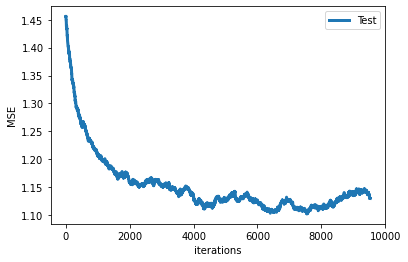

In [54]:
plot_learning_curve(als)

In [55]:
als.test_mse_record[-1]

1.1299652582763866